In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random
from astropy.io import fits
from tqdm import tqdm
from astropy.table import Table
import os 
import array as arr
import math as m
import statistics as st
import matplotlib as mpl
from matplotlib import path
import seaborn as sns #used for plotting kernel density plots
import pandas as pd #used for turning data into dataframes(tables)
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel 
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import pdb

In [2]:
plt.rc('font', size=20)

In [3]:
data = Table.read("2022B_PHAST.fits",format='fits')
print(data.colnames)
print(len(data))

spectra = np.load("2022B_PHAST_Spectra (1).npy")
#ivar = np.load("LMC_ivar.npy")

wavln = spectra[0,:,:]
flux = spectra[1,:,:]
ivar = spectra[2,:,:]
print(spectra.shape)

['RA [rad]', 'DEC [rad]', 'Z', 'Z ERROR', 'OBJECTNAME', 'ZQUALITY', 'F814W [mag]', 'F475W [mag]']
3441
(3, 3441, 10770)


In [4]:
data.info()

<Table length=3441>
    name     dtype 
----------- -------
   RA [rad] float32
  DEC [rad] float32
          Z float32
    Z ERROR float32
 OBJECTNAME  bytes9
   ZQUALITY float32
F814W [mag] float32
F475W [mag] float32


In [5]:
print(data)

 RA [rad]  DEC [rad]        Z        ... ZQUALITY F814W [mag] F475W [mag]
---------- ---------- -------------- ... -------- ----------- -----------
0.18664478   0.712537  -0.0006799102 ...      4.0   20.956501      24.667
0.18642153  0.7125903 -0.00053703785 ...      4.0     21.0015   24.342999
 0.1867335 0.71259415  -0.0005624294 ...      4.0     21.9275       24.57
0.18623172     0.7126  -0.0020657778 ...      4.0      21.027   24.324501
 0.1865866  0.7126645  -0.0007584095 ...      2.0      21.204   24.883999
0.18613428    0.71268 -0.00042527914 ...      4.0   20.830502   23.384998
0.18634371 0.71268386 -0.00084221363 ...      4.0     21.0935     23.6635
0.18666296  0.7127173  -0.0007554889 ...      4.0      21.122       25.34
0.18610156  0.7127411  -0.0007042289 ...      4.0     21.0005     24.9645
0.18646733 0.71278036  -0.0005623698 ...      4.0   20.668999      24.022
       ...        ...            ... ...      ...         ...         ...
0.17661205  0.7093382  -0.0018160939 .

In [6]:
f475w = data["F475W [mag]"]
f814w = data["F814W [mag]"]

In [7]:
## This is where you run through a few of the spectra until you find 10 spectra of each type (weak CN and carbon)
## Keep saving the index of each spectra in the arrays below

Wnm = [2894, 2119, 2912, 2177, 2562, 2574, 454, 2395, 3110, 1528, 2279, 1430, 3290, 2007] # add 10 weak cn index (more is fine)
allcarbon = [809, 1857, 506, 745, 2409, 1058] #add 10 carbon star index (more is fine)

Example of a Weak CN Star. Note the "W" shaped CN feature centered at around 8000 angstroms

![Alt text](image.png)

Example of a Carbon Star. Note how the CN feature is much much stronger and we do not see the Calcium triplet at all!

![Alt text](image-1.png)

2126


(7000.0, 8800.0)

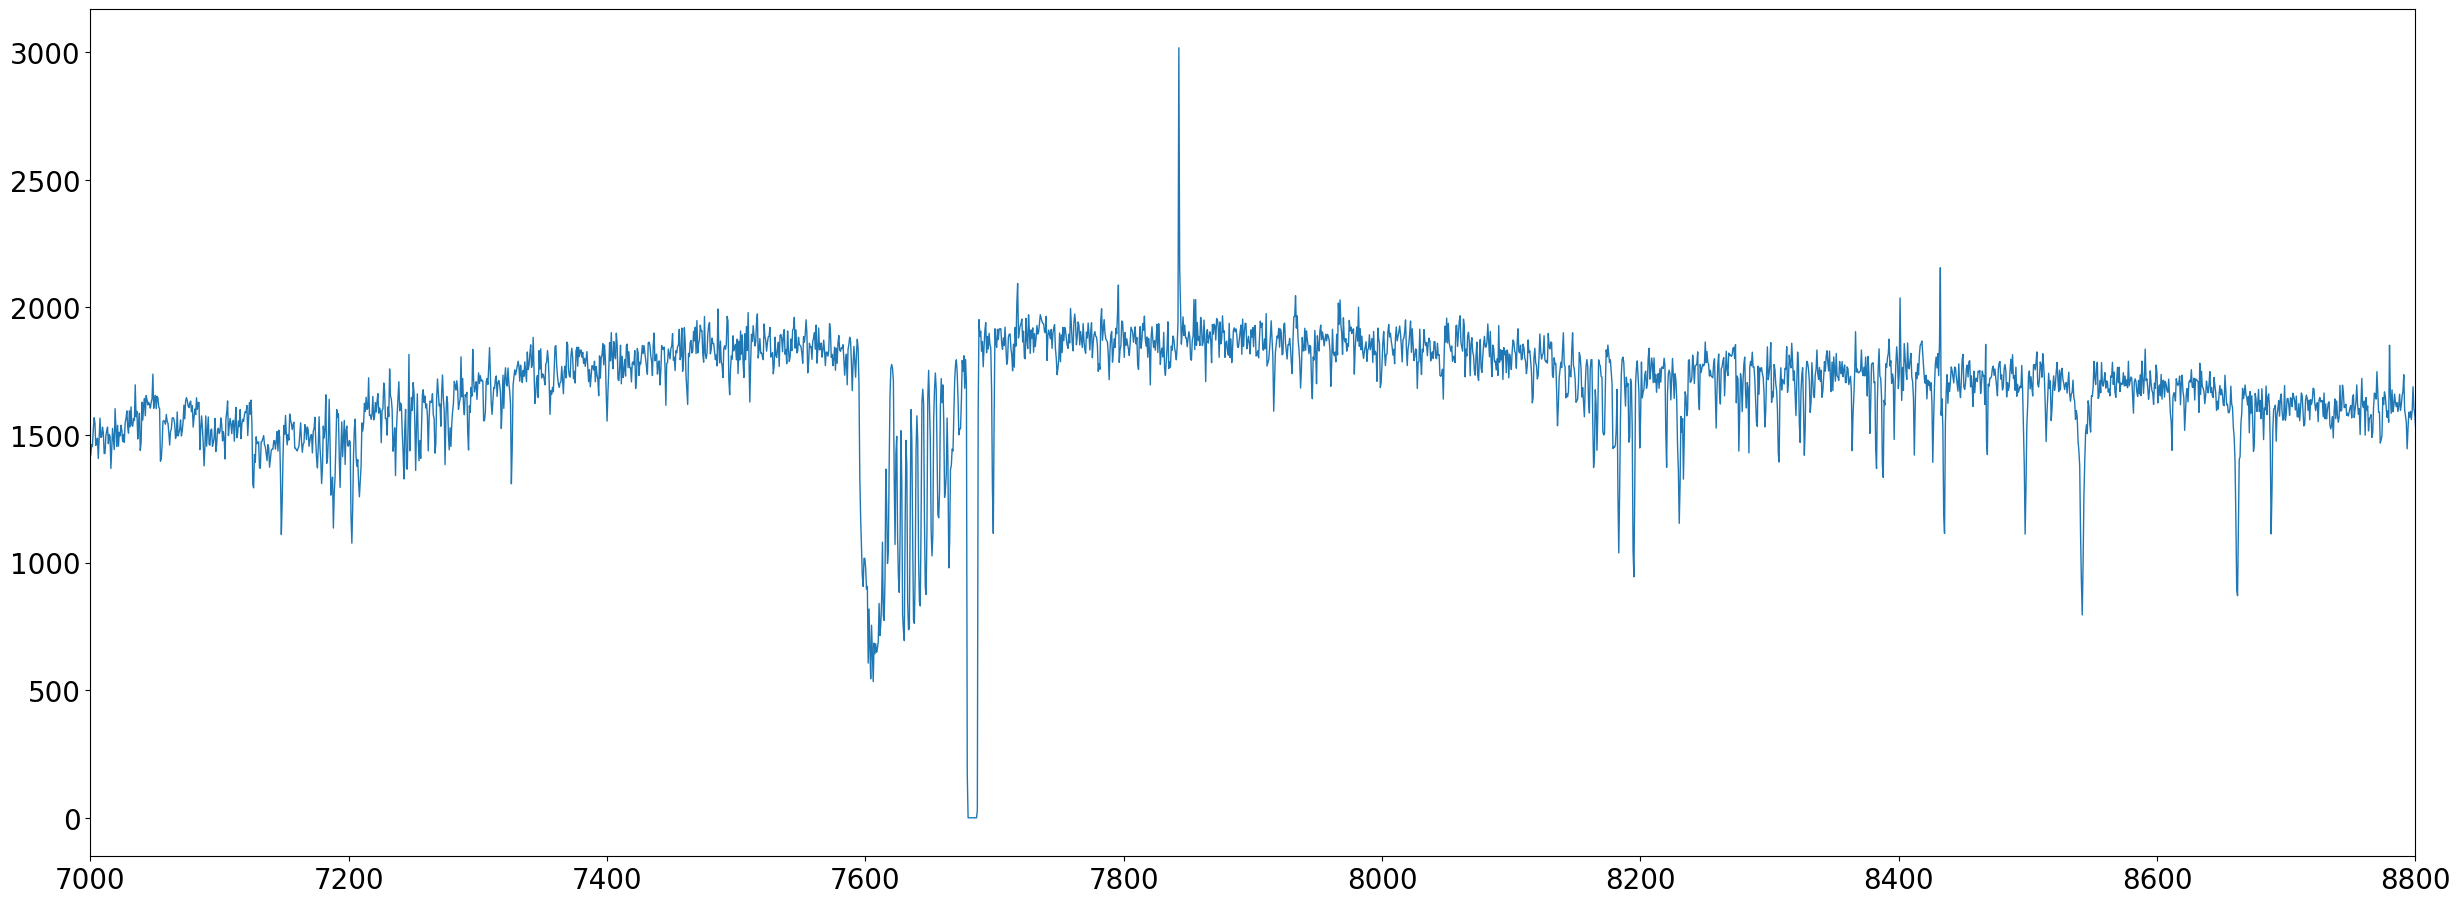

In [8]:
rnd = random.randint(0, 3441) #Selects a random star in the dataset
print(rnd) #prints its index. If this star happens to be weak CN, put this number in the appropriate array above. 
           #Same for Carbon Star

plt.figure(figsize=(30,11)) #plots the spectra
plt.plot(wavln[rnd,:], flux[rnd,:], lw=1)
plt.xlim(7000, 8800)

9


(7000.0, 8800.0)

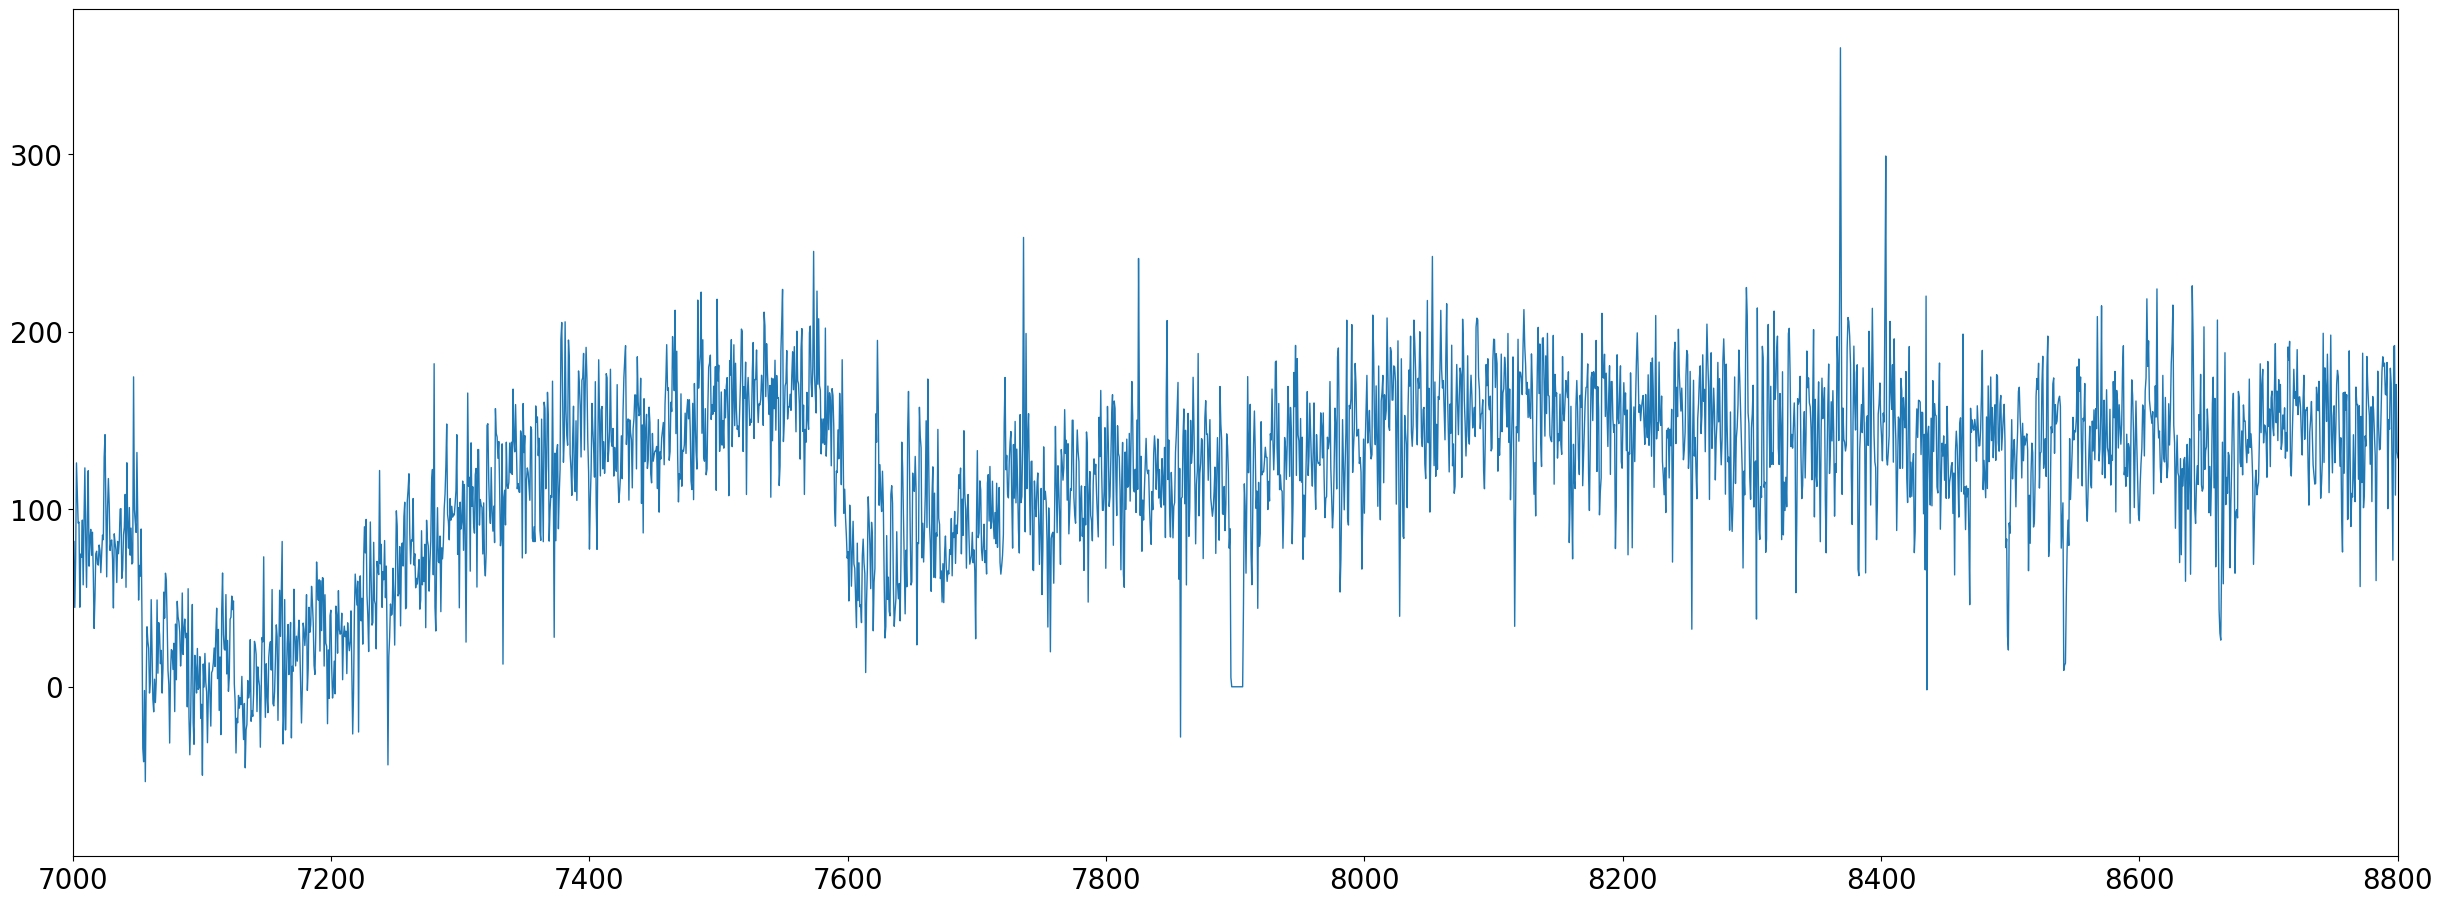

In [9]:
num = 9
print(num)
plt.figure(figsize=(30,11)) #plots the spectra
plt.plot(wavln[num,:], flux[num,:], lw=1)
plt.xlim(7000, 8800)

In [10]:
## ONLY RUN THIS ONCE YOU HAVE FILLED THE ARRAYS WITH 10 EXAMPLES EACH OF CARBON AND WEAK CN STARS

others = np.arange(0, len(wavln[0,:]), 1)
delete = np.append(allcarbon, Wnm)
others = np.delete(others, delete)

In [11]:
#defines variables that will be used for clipping spectra to the right wavelength window
#goal: isolate the 'W' shaped feature shared by carbon and weak CN stars
lowerThresh = 5840         #represents 7796.0 angstroms in data["LBIN"]
upperThresh = 6550         #represents 8257.5 angstroms in data["LBIN"]
middleThresh = 6184        #represents 8019.6 angstroms in data["LBIN"]; point between the two 'U's

fullSpec_low = 0
fullSpec_high = len(wavln[0,:])

In [12]:
#performing a NaN cut on the stars to eliminate any whose spectra are more than 10% NaNs on the 'W' range
NANvalidstars_list = np.arange(0, len(wavln[:,0]), 1)
for star in range(0, len(wavln[:,0])):
    NANcount = 0
    for f in flux[star, lowerThresh:upperThresh]:
        if np.isnan(f):
            NANcount += 1
    if NANcount > 0.1*len(flux[:, lowerThresh:upperThresh]):
        NANvalidstars_list.remove(star)
NANvalidstars = np.array(NANvalidstars_list)

#metadata: showing how many stars were cut out of the data due to the NaN limits
print(str(len(wavln[:,0])) + ' stars became ' + str(len(NANvalidstars)) + ' after the NaN cut.')

AttributeError: 'numpy.ndarray' object has no attribute 'remove'

In [13]:
#defines a function that will slice any spectrum to desired wavelengths
def sliceSpec(star, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    lower: the lower boundary of the slice, in terms of wavelength
    upper: the upper boundary of the slice, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    
    Returns newWv, a Numpy array containing every wavelength value between lower and upper for which data exists for a certain star 
    Also returns newFlux, a Numpy array containing the flux values that (for a certain star) correspond to each of the wavelength values in newSpec
    Also returns newIvar, a Numpy array containing the ivar values that (for a certain star) corresopnd to each of the wavelength values in newSpec
    '''
    newWv = wavln[star][lower:upper]
    newFlux = flux[star][lower:upper]
    newIvar = ivar[star][lower:upper]
    return newWv, newFlux, newIvar

In [14]:
def normspec(star, lower = lowerThresh, upper = upperThresh):
    wvSlice, fluxSlice, ivarSlice = sliceSpec(star, lower, upper)
    
    
    nan1 = fluxSlice==0
    fluxSlice[nan1] = np.nan
    ivarSlice[nan1] = 0
    
    nan2 = ivarSlice ==0
    fluxSlice[nan2] = np.nan
    ivarSlice[nan2] =0
    
    wvSlice_list = wvSlice.tolist()
    fluxSlice_list = fluxSlice.tolist()
    ivarSlice_list = ivarSlice.tolist()
    
    #creating a version of the spectrum without any NaNs for performing median/standard deviation calculations
    #if the spectrum is all NaNs on the range specified in the function call, will return an error
    #if the spectrum is all 0s on the range specified in the function call, will replace the 0s with NaNs and returm am error
    newFluxSlice = []
    for wv in range(len(fluxSlice_list)):
        if np.isnan(ivarSlice_list[wv]) or np.isnan(fluxSlice_list[wv]):
            ivarSlice_list[wv] = 0
        else: #add to "non-zero, non-NaN" data
            newFluxSlice.append(fluxSlice_list[wv])
    if newFluxSlice == []:
        print("NormalizationError: The spectrum for star " + str(star) + " contains only NaN values on the specified range. It cannot be normalized.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    
    medianFlux = st.median(newFluxSlice)
    spec_mean = st.mean(newFluxSlice)
    spec_stdev = st.stdev(newFluxSlice)
    upperLim = spec_mean + 5*spec_stdev #limits calculated to clip out values around nan
    lowerLim = spec_mean - 5*spec_stdev
    
    #replaces with np.nan values that are within 5 pixels of a nan value and outside of 5 standard deviations from the mean flux 
    #accomodates for nan values being located on the edges of the spectrum (in positions where 5 pixels out in either direction would be out of range)
    nanIndices = []
    for index in range(len(fluxSlice_list)):
        if np.isnan(fluxSlice_list[index]): 
            if 5 < index < len(wvSlice_list) - 5:
                for i in range(index-5,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif 5 > index:
                for i in range(0,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif index > len(wvSlice_list) - 5:
                for i in range(index-5, len(wvSlice)): #this should go upto len(specSlice)-1 due to 0-indexing
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
    
    #at each pixel, normalizes the star's spectrum and modifies the corresponding ivar value
    normedFlux = fluxSlice/medianFlux
    normedIvar = ivarSlice*medianFlux**2
    
    #converts the final products back to arrays for easy manipulation later in the code
    normedFlux_np = np.array(normedFlux)
    normedIvar_np = np.array(normedIvar)
    wvSlice_np = np.array(wvSlice)
    
    return wvSlice_np, normedFlux_np, normedIvar_np, True

In [15]:
#creates splashSpecs_dict, a dictionary of the normalized spectra for every valid star in SPLASH, and splashIvars_dict, a dictionary of the normalized ivar values for those same stars
#keys are the indices of stars, paired values are arrays representing the flux/ivar values of those stars at every wavelength in the range identified
#note that NormalizationError messages may appear if stars that cannot be normalized; in these cases, star index keys are paired with arrays of NaN values in splashSpecs_dict and arrays of 0s in splashIvars_dict (because ivar = 0 for every NaN)
splashSpecs_dict, splashIvars_dict, splashSuccess_dict = {}, {}, {}

#creates a list of stars with high median ivars to later test against their brightnesses
highIvarStars = []

#create lists of median ivars for every star (without including NaN or 0 medians)
#also sets up dictionaries of star:medianIvar for later use in ivar trimming, etc
#note that if a star's spectrum could not be normalized, it will be excluded from these dictionaries (rather than paired with NaNs as was done earlier)
wNm_ivarMeds, carbon_ivarMeds, kphOthers_ivarMeds = [], [], []
wNm_ivarMeds_dict, carbon_ivarMeds_dict, kphOthers_ivarMeds_dict = {}, {}, {}

IVAR_LIMIT = 1000 #an arbitrary constant that acts as the defining limit for what counts as a high-ivar star

for star in tqdm(range(0, len(wavln[:,0]))):
    #the following lines are done for all stars, as a part of the base dictionary creation
    spSlice, normSp, normIv, success = normspec(star = star)
    splashSpecs_dict[star], splashIvars_dict[star], splashSuccess_dict[star] = normSp, normIv, success
    
    #now, based on star type (wNm, carbon, other, highIvar), normIv is added to its corresponding list to be used in subsequent ivar trimming and graphs
    if success: #if the star could not be normalized, then won't be needed in trimming/statistical analyses
        if star in Wnm:
            med = np.nanmedian(normIv)
            if med != 0:
                wNm_ivarMeds.append(med); wNm_ivarMeds_dict[star] = med
        if star in allcarbon:
            med = np.nanmedian(normIv)
            if med != 0:
                carbon_ivarMeds.append(med); carbon_ivarMeds_dict[star] = med
        if np.nanmedian(normIv) > IVAR_LIMIT:
            highIvarStars.append(star)
        if star in others:
            med = np.nanmedian(normIv)
            if med != 0:
                kphOthers_ivarMeds.append(med); kphOthers_ivarMeds_dict[star] = med

  7%|▋         | 254/3441 [00:01<00:13, 232.04it/s]

NormalizationError: The spectrum for star 211 contains only NaN values on the specified range. It cannot be normalized.


  9%|▉         | 303/3441 [00:01<00:13, 226.56it/s]

NormalizationError: The spectrum for star 270 contains only NaN values on the specified range. It cannot be normalized.


 13%|█▎        | 443/3441 [00:01<00:13, 224.56it/s]

NormalizationError: The spectrum for star 410 contains only NaN values on the specified range. It cannot be normalized.


 55%|█████▌    | 1900/3441 [00:08<00:06, 242.01it/s]

NormalizationError: The spectrum for star 1866 contains only NaN values on the specified range. It cannot be normalized.


 57%|█████▋    | 1969/3441 [00:08<00:07, 203.89it/s]

NormalizationError: The spectrum for star 1946 contains only NaN values on the specified range. It cannot be normalized.


 61%|██████▏   | 2114/3441 [00:09<00:07, 184.66it/s]

NormalizationError: The spectrum for star 2093 contains only NaN values on the specified range. It cannot be normalized.


 64%|██████▍   | 2219/3441 [00:09<00:06, 202.06it/s]

NormalizationError: The spectrum for star 2189 contains only NaN values on the specified range. It cannot be normalized.


 72%|███████▏  | 2472/3441 [00:11<00:05, 180.57it/s]

NormalizationError: The spectrum for star 2446 contains only NaN values on the specified range. It cannot be normalized.


 82%|████████▏ | 2821/3441 [00:12<00:02, 243.26it/s]

NormalizationError: The spectrum for star 2782 contains only NaN values on the specified range. It cannot be normalized.


 90%|█████████ | 3097/3441 [00:13<00:01, 226.52it/s]

NormalizationError: The spectrum for star 3052 contains only NaN values on the specified range. It cannot be normalized.


100%|██████████| 3441/3441 [00:15<00:00, 224.88it/s]


In [16]:
#defines a function that clips out outlier data points in a set of spectra 
#outliers are defined as points that lie outside of a certain number of standard deviations away from the median flux value at each wavelength
def sigmaClip(spectra, ivars, nsigma = 3.5):
    '''
    spectra: a list of the spectra of each star that is being clipped
    ivars: a list of the sets of ivars for each star that is being coadded
    nsigma: an integer or float representing the number of standard deviations away from the median to be used in clipping
    
    nsigma will default to 3.5 unless otherwise specified
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns spectra, a list of the spectra of each star in terms of flux
    Also returns ivars, a list of the set of ivars of each star with values corresponding to the invalid values in spectra (those that lie more than nsigma standard deviations away from the median) replaced by 0s
    '''
    sortedSpecList = []
    for value in range(len(spectra[1])): #note that the use of spectra[1] is arbitrary as all of the lists in spectra have the same length
        listToAdd = []
        for spectrum in range(len(spectra)):
            if not np.isnan(spectra[spectrum][value]):
                listToAdd.append(spectra[spectrum][value])
        sortedSpecList.append(listToAdd)
    medians = []
    for eachlist in range(len(sortedSpecList)):
        if len(sortedSpecList[eachlist]) != 0:
            medians.append(st.median(sortedSpecList[eachlist]))
        else: 
            medians.append(np.nan)
    for spectrum in range(len(spectra)):
        for flux in range(len(spectra[1])): #see above comment
            if np.isnan(medians[flux]):
                continue
            elif ivars[spectrum][flux] != 0 and not np.isnan(spectra[spectrum][flux]):
                testFlux = ((spectra[spectrum][flux] - medians[flux])**2)*ivars[spectrum][flux] 
                if testFlux > nsigma**2:
                    spectra[spectrum][flux] = np.nan
                    ivars[spectrum][flux] = 0          
    return spectra, ivars

In [17]:
#defines a function that will coadd normalized spectra based on provided lists of spectra and ivar weights
def coadd(spectra, ivars, lower = lowerThresh, upper = upperThresh):
    '''
    spectra: a list of the spectra of each star that is being coadded
    ivars: a list of the sets of ivars for each star that is being coadded
    lower: the lower boundary of the range the spectrum have been normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum have been normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns wvValues_np, a Numpy array containing every wavelength value for which spectral data exists between lower and upper
    Also returns coaddedFlux_np, a Numpy array containing the flux values of the coadded spectrum corresponding to each wavelength in wvValues_np 
    Also returns coaddedIvar_np, a Numpy array containing the ivar values of the coadded spectrum corresponding to each wavelength in  wvValues_np
    '''
    wvValues = wavln[0, lower:upper].tolist()
    coaddedFlux = []
    coaddedIvar = []
    for wv in range(len(wvValues)):
        fluxSum = 0
        ivarSum = 0
        for star in range(len(spectra)):
            if not np.isnan(spectra[star][wv]): 
                fluxSum += spectra[star][wv] * ivars[star][wv] #multiplying by ivar as a weight, as per formula
                ivarSum += ivars[star][wv]
        if ivarSum == 0:
            coaddedFlux.append(np.nan)
            coaddedIvar.append(0)
        else:
            newFlux = fluxSum/ivarSum #normalizing the weights, as per formula
            coaddedFlux.append(newFlux) #coaddedSpec now contains a coadded spectrum value at each LBIN value
            coaddedIvar.append(ivarSum) #coadded ivar is simply the sum of all ivars for a certain bin, across all stars (based on a mathematical proof)
    for flux in range(len(coaddedFlux)):
        if coaddedFlux[flux] == 0:
            coaddedFlux[flux] = np.nan
    coaddedFlux_np = np.asarray(coaddedFlux)
    wvValues_np = np.asarray(wvValues)
    coaddedIvar_np = np.asarray(coaddedIvar)
    return wvValues_np, coaddedFlux_np, coaddedIvar_np

In [18]:
def rms(spectra, coad, lower = lowerThresh, upper = upperThresh):
    
    wvValues = wavln[0, lower:upper].tolist()
    spectra = np.asarray(spectra)
    
    N = len(wvValues)
    rms_squared = np.zeros(shape=N)
    for wv in range(N):
        rms_squared[wv] = np.nansum((spectra[:,wv]-coad[wv])**2)
        
    rms = np.sqrt(rms_squared/(N-1))
    return rms

In [19]:
#defines a function that creates a coadded template spectrum by combining several spectra normalized over a certain range
def getTempSpec(starIndices, lower = lowerThresh, upper = upperThresh, nsigma = 3.5):
    '''
    starIndices: an array or list of the indices of the stars to be coadded (which correspond to spectra in SPLASH)
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    nsigma: a numerical value representing the number of standard deviations away from the flux medians that data for the coaddition will be trimmed to
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    nsigma will default to 3.5 unless another value is provided
    
    Returns coadd_wv, the set of all wavelength values for which data exists in the final coadded spectrum
    Also returns coadd_spec, the set of all flux values that correspond to the wavelength values in coadd_wv for the final coadded spectrum
    Also returns coadd_ivar, the number representing the ivar for every wavelength value on the final coadded spectrum
    Note that the final spectrum has been created from nsigma clipped data
    '''
    #creating lists of normalized spectra and ivars for each star to be coadded
    spectra = []
    ivars = []
    for star in starIndices:
        if lower == lowerThresh and upper == upperThresh:
            #spectra.append(applyGauss(splashSpecs_dict[star],gauss=6).tolist())
            spectra.append(splashSpecs_dict[star].tolist())
            ivars.append(splashIvars_dict[star].tolist())
        else:
            starSpec, starIvar = normspec(star = star, lower = lower, upper = upper)[1:3]
            #starSpec = applyGauss(starSpec,gauss=6)
            spectra.append(starSpec.tolist())
            ivars.append(starIvar.tolist())
    print("Step 1 of 3 complete. Normalized spectra and inverse variances loaded.")

    #takes the original data and replaces with NaN values any data points that are greater than nsigma standard deviations from the median
    #the median is defined as the median flux at each wavelength when the flux values for every spectrum at that wavelength are considered
    spectra_new, ivars_new = sigmaClip(spectra, ivars, nsigma)
    print("Step 2 of 3 complete. Spectral and ivar data clipped to " + str(nsigma) + " sigmas.")

    #performs the coaddition with the edited data from the last step
    coadd_wv, coadd_spec, coadd_ivar = coadd(spectra_new, ivars_new, lower, upper)
    print("Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.")
    
    rms_new = rms(spectra_new, coadd_spec, lower, upper)
    
    return coadd_wv, coadd_spec, coadd_ivar, rms_new

In [20]:
#Generates Template Spectra for Carbon and Weak CN stars both in full wavelength space and just in the CN wavelength range

Ctemplate_wv, Ctemplate, Ctemplate_ivar, rms_C = getTempSpec(allcarbon)
Ctemplate_wv_full, Ctemplate_full, Ctemplate_ivar_full, rms_C_full = getTempSpec(allcarbon, lower = fullSpec_low, upper = fullSpec_high)
Wtemplate_wv, Wtemplate, Wtemplate_ivar,rms_W = getTempSpec(Wnm)
Wtemplate_wv_full, Wtemplate_full, Wtemplate_ivar_full,rms_W_full = getTempSpec(Wnm, lower = fullSpec_low, upper = fullSpec_high)

Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.


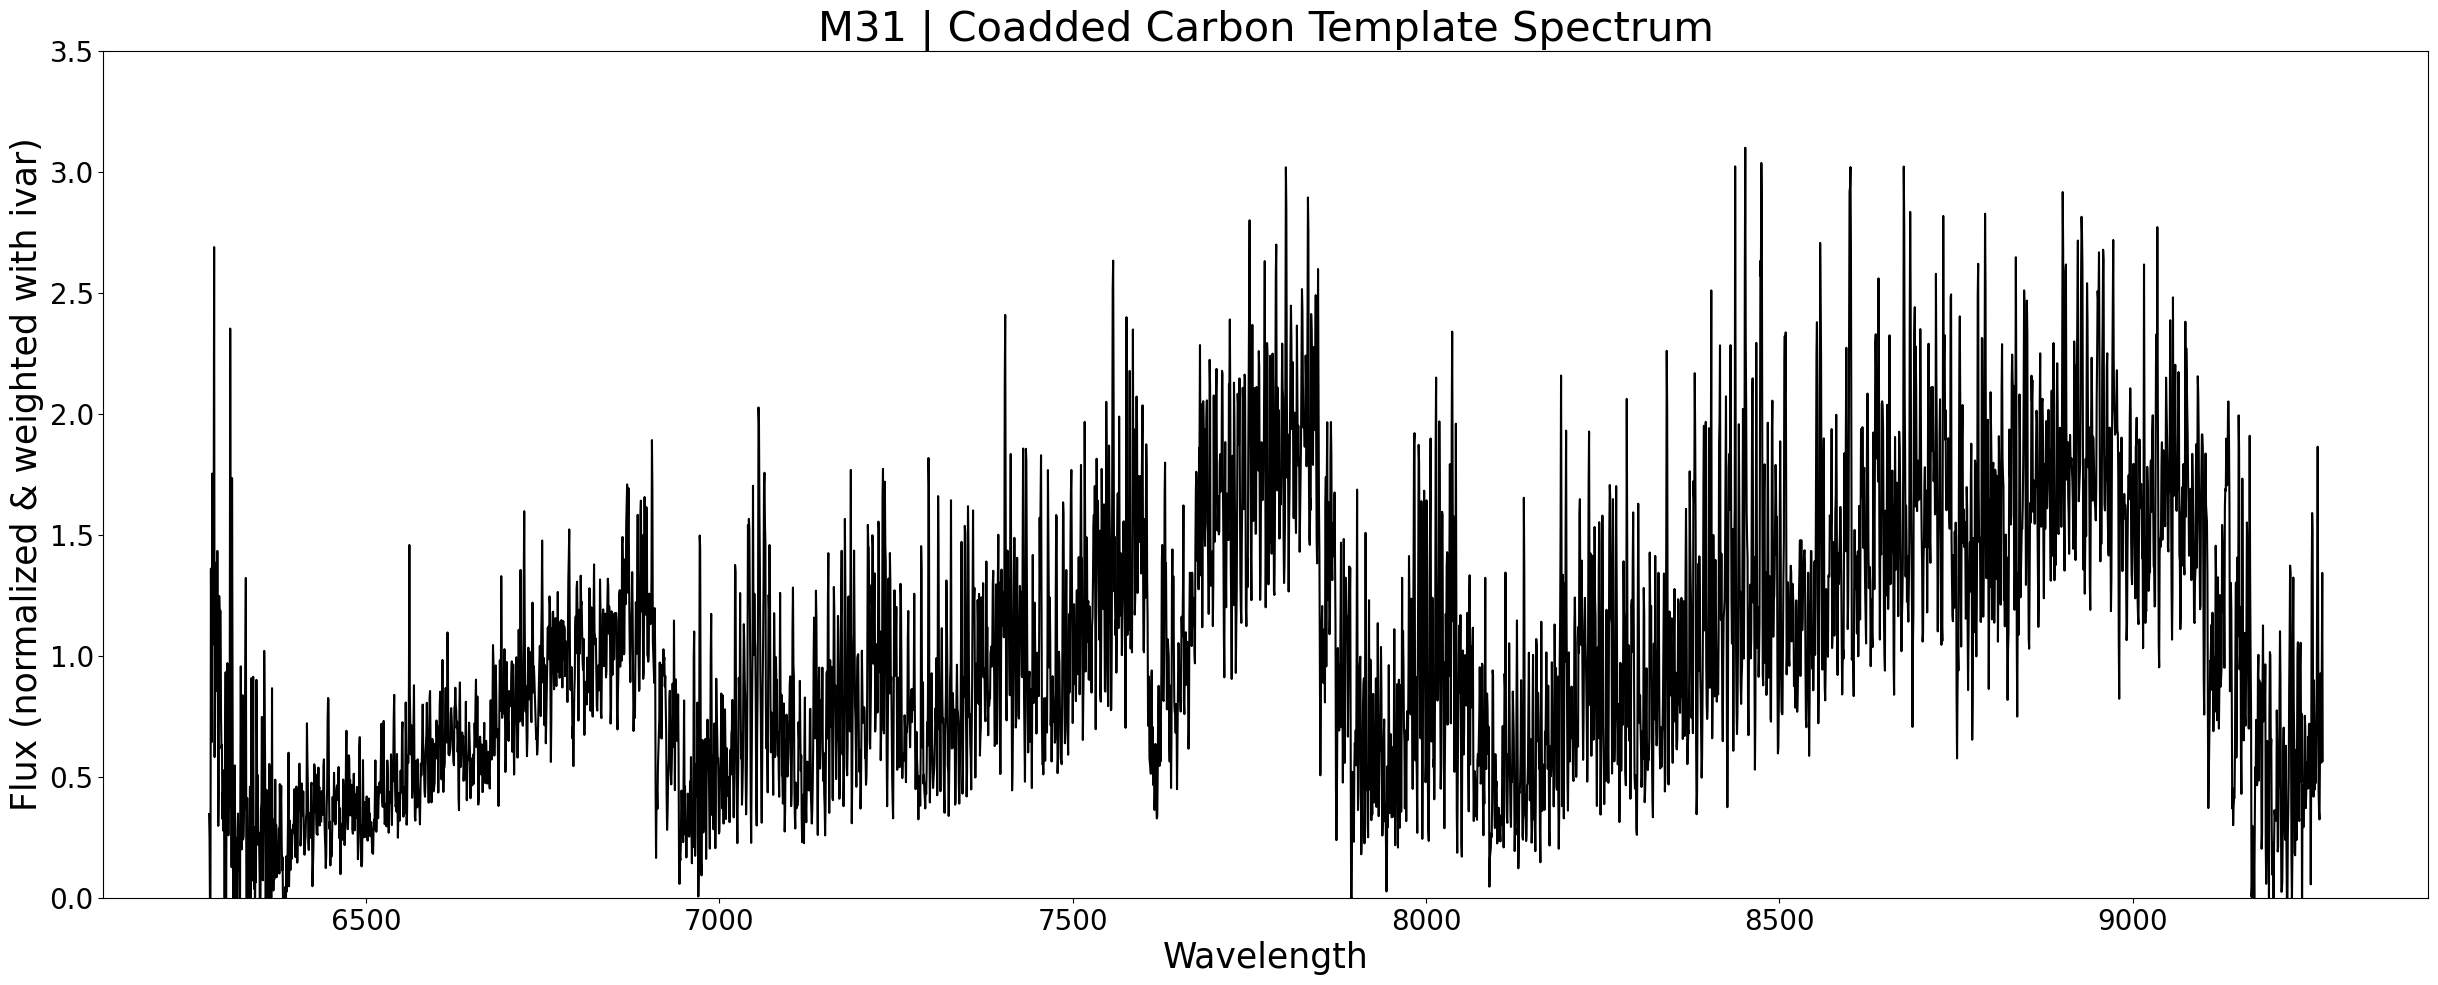

In [21]:
#Plots Carbon Star Template. Make sure this looks ok

x = Ctemplate_wv_full
y = Ctemplate_full
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y, c='k')
plt.title("M31 | Coadded Carbon Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 25)
plt.xlabel("Wavelength", size = 25)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.ylim(0,3.5)
plt.show()

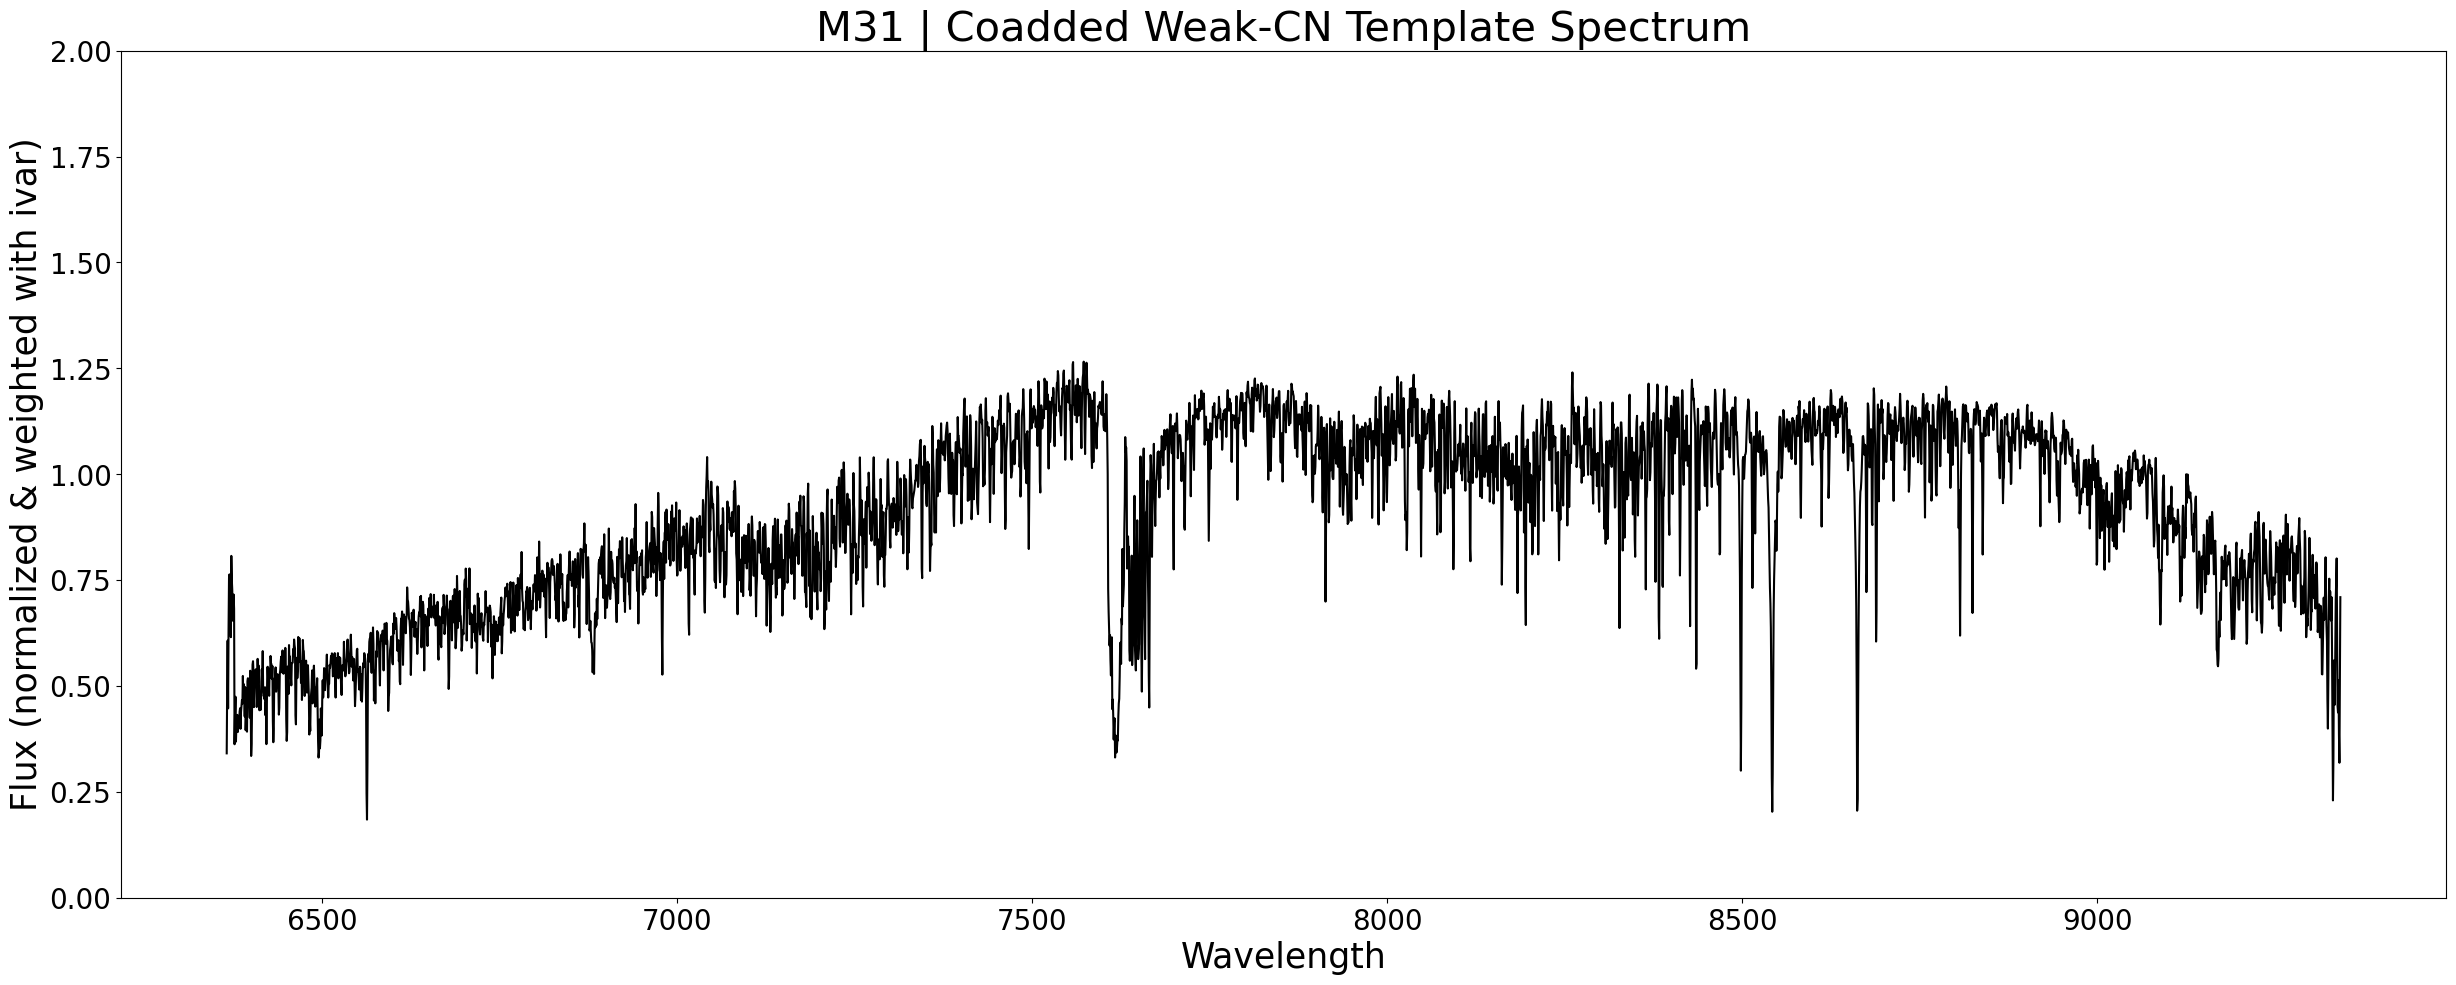

In [22]:
#Plots Weak CN Template. Make sure this looks ok

x = Wtemplate_wv_full
y = Wtemplate_full
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y, c='k')
plt.title("M31 | Coadded Weak-CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 25)
plt.xlabel("Wavelength", size = 25)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.ylim(0,2)
plt.show()

In [23]:
#Creating a function to normalize all the spectra in my dataset
def get_normed_spectra(starIndices, lower = lowerThresh, upper = upperThresh, nsigma = 3.5):
    #creating lists of normalized spectra and ivars for each star to be coadded
    spectra = []
    ivars = []
    for star in starIndices:
        if lower == lowerThresh and upper == upperThresh:
            #spectra.append(applyGauss(splashSpecs_dict[star],gauss=6).tolist())
            spectra.append(splashSpecs_dict[star].tolist())
            ivars.append(splashIvars_dict[star].tolist())
        else:
            starSpec, starIvar = normspec(star = star, lower = lower, upper = upper)[1:3]
            #starSpec = applyGauss(starSpec,gauss=6)
            spectra.append(starSpec.tolist())
            ivars.append(starIvar.tolist())
    print("Step 1 of 3 complete. Normalized spectra and inverse variances loaded.")

    #takes the original data and replaces with NaN values any data points that are greater than nsigma standard deviations from the median
    #the median is defined as the median flux at each wavelength when the flux values for every spectrum at that wavelength are considered
    spectra_new, ivars_new = sigmaClip(spectra, ivars, nsigma)
    print("Step 2 of 3 complete. Spectral and ivar data clipped to " + str(nsigma) + " sigmas.")
    
    return np.asarray(spectra_new), np.asarray(ivars_new)

In [24]:
#normalizing the entire dataset
keckPhotoOthers = np.arange(0, len(wavln[:,0]),1) #index of all stars (0 to 8011)
NormFlux_w_full, NormIvar_w_full = get_normed_spectra(keckPhotoOthers) #normalized flux and ivar

print(Wtemplate.shape) #printing the shape to make sure the wavelength dimension is all the same
print(Ctemplate.shape)
print(NormFlux_w_full.shape)

Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
(710,)
(710,)
(3441, 710)


In [25]:
#Sets a score depending on how similar a spectra is to a given template
def getScore(templateSpec, scienceSpec, ivars):
    '''
    templateSpec: a Numpy array containing the flux values of the coadded template spectrum
    scienceSpec: a Numpy array containing the flux values at each wavelength of the normalized spectrum for a specific star
    ivars: a Numpy array containing the normalized ivar values at each wavelength of the spectrum for a specific star
    
    Returns finalScore, a float representing the similarity between the two spectra. A lower score indicates greater similarity and a higher score indicates lower similarity
    Note that spectra that cannot be normalized will not have a score associated with them. The function returns a NaN as the score for these spectra
    '''
    templateSpec_list = templateSpec.tolist()
    scienceSpec_list = scienceSpec[~np.isnan(scienceSpec)].tolist()
    if scienceSpec_list == []:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan
    else:
        summedScore = 0
        for wv in range(len(templateSpec_list)):
            score = ((scienceSpec[wv] - templateSpec[wv])**2) * ivars[wv]
            if not np.isnan(score):
                summedScore += score
        summedIvars = 0
        for ivar in ivars:
            if not np.isnan(ivar):
                summedIvars += ivar
        finalScore = (summedScore/summedIvars)**0.5
        return finalScore

In [26]:
#defines an important variable that will be used for finding the slopes of spectra
#the slope will not be calculated based on random points, but on the median point in a small "window" at either end of the spectrum
slopeWindow = 25

#defines a function that calculates the slope of a spectrum's wavelength vs flux graph on a certain interval
def getSlope2(spectrum, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a list containing the sliced, normalized flux values of the spectrum to be analyzed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    
    lower and upper will default to the previously defined lowerThresh and upperThresh values, respectively
    
    Returns slope, a numerical value representing the slope of the spectrum on the wavelength range lower to upper
    '''
    lowerInt, upperInt, = spectrum[:slopeWindow], spectrum[-slopeWindow:]
    lowerMedian = np.nanmedian(lowerInt)
    upperMedian = np.nanmedian(upperInt)
    diff = (wavln[0,upper] - wavln[0,lower])
    slope = (upperMedian - lowerMedian)/diff
    return slope

#defines a function that modifies the slope of a spectrum by distorting the graph
def getTiltedSpec2(spectrum, slope, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be modified
    slope: a numerical value (most often a float) containing the slope to be applied to the spectrum
    lower: the index of the lower boundary of spectrum in data["LBIN"]
    upper: the index of the upper boundary of spectrum in data["LBIN"]
    
    Note that lower and upper will default to the predefined lowerThresh and upperThresh, respectively
    
    Returns titled, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    
    deltaLam = wavln[0, lower:upper] - wavln[0,lower] #note that the used of data["LBIN"][0] is arbitrary because all spectra have the same LBIN data values
    tilted = slope*deltaLam + spectrum #creating a copy of the spectrum with the new slope
    tilted = tilted/np.nanmedian(tilted) #normalizes the spectrum again
    return tilted

#defines a function that scales a spectrum by either enhancing or reducing spectral features
def getScaledSpec2(spectrum, c):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be scaled
    c: a numerical value representing the scale factor by which the spectrum will be modified
    
    Returns scaledFlux, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    if c == -1: #accounts for potential divide by zero errors in scaling function
        raise ZeroDivisionError("c cannot be -1 due to the structure of the scaling formula.")
    scaledFlux = (spectrum + c)/(1+c)
    return scaledFlux


#defines a helper function for findOptimalC that produces a list of all the c-values to be tested
def getRanger2(start, stop, step, zoomStart = None, zoomStop = None, zoomStep = None):
    '''
    start: a numerical value representing the lowest value of c you want to test
    stop: a numerical value representing the highest value of c you want to test
    step: a numerical value representing the increment at which you want to create new values of c between start and stop
    zoomStart: a numerical value representing the lowest value of c you want to test with a finer step size
    zoomStop: a numerical value representing the highest value of c you want to test with a finer step size
    zoomStep: a numerical value representing the finer step size to be applied between zoomStop and zoomStart
    
    Note that zoomStart, zoomStop, and zoomStep will all default to None.
    
    Returns rangeList, a list of the scale-factor (c) values to be iterated over for a star that is undergoing the template-matching process
    '''
    rangeList = []
    c = 0
    rangeList.append(c)
    return rangeList

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findWOptimalC2(star, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normspec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normspec(star = star, lower = lower, upper = upper)[1:3]
    
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    for c in getRanger2(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec2(clipTemplate, c)
        s = slope - getSlope2(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

def findCOptimalC2(star, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normspec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normspec(star = star, lower = lower, upper = upper)[1:3]

    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    for c in getRanger2(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec2(clipTemplate, c)
        s = slope - getSlope2(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

In [27]:
chi_new_WCN = []
chi_new_C = []
for star in tqdm(range(0, len(wavln[:,0]))):
    c, s, sc = findCOptimalC2(star)
    chi_new_C.append(sc)
    
    c, s, sc = findWOptimalC2(star)
    chi_new_WCN.append(sc)

  6%|▋         | 218/3441 [00:04<01:14, 43.06it/s]

NormalizationError: The spectrum for star 211 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 211 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


  8%|▊         | 278/3441 [00:05<01:01, 51.78it/s]

NormalizationError: The spectrum for star 270 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 270 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 12%|█▏        | 416/3441 [00:08<01:00, 50.07it/s]

NormalizationError: The spectrum for star 410 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 410 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 54%|█████▍    | 1874/3441 [00:39<00:30, 51.33it/s]

NormalizationError: The spectrum for star 1866 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 1866 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 57%|█████▋    | 1956/3441 [00:41<00:30, 49.45it/s]

NormalizationError: The spectrum for star 1946 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 1946 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 61%|██████    | 2103/3441 [00:44<00:24, 53.78it/s]

NormalizationError: The spectrum for star 2093 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 2093 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 64%|██████▍   | 2199/3441 [00:46<00:28, 43.55it/s]

NormalizationError: The spectrum for star 2189 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 2189 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 71%|███████▏  | 2455/3441 [00:51<00:18, 52.02it/s]

NormalizationError: The spectrum for star 2446 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 2446 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 81%|████████  | 2789/3441 [00:58<00:12, 51.02it/s]

NormalizationError: The spectrum for star 2782 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 2782 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


 89%|████████▉ | 3062/3441 [01:04<00:08, 45.91it/s]

NormalizationError: The spectrum for star 3052 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.
NormalizationError: The spectrum for star 3052 contains only NaN values on the specified range. It cannot be normalized.
ScoreError: Because this spectrum cannot be normalized, its score cannot be found.


100%|██████████| 3441/3441 [01:11<00:00, 47.83it/s]


In [28]:
chi_squared_list_C = np.asarray(chi_new_C)
chi_squared_list_WCN = np.asarray(chi_new_WCN)
print(chi_squared_list_C.shape)

(3441,)


(-0.1, 1.3)

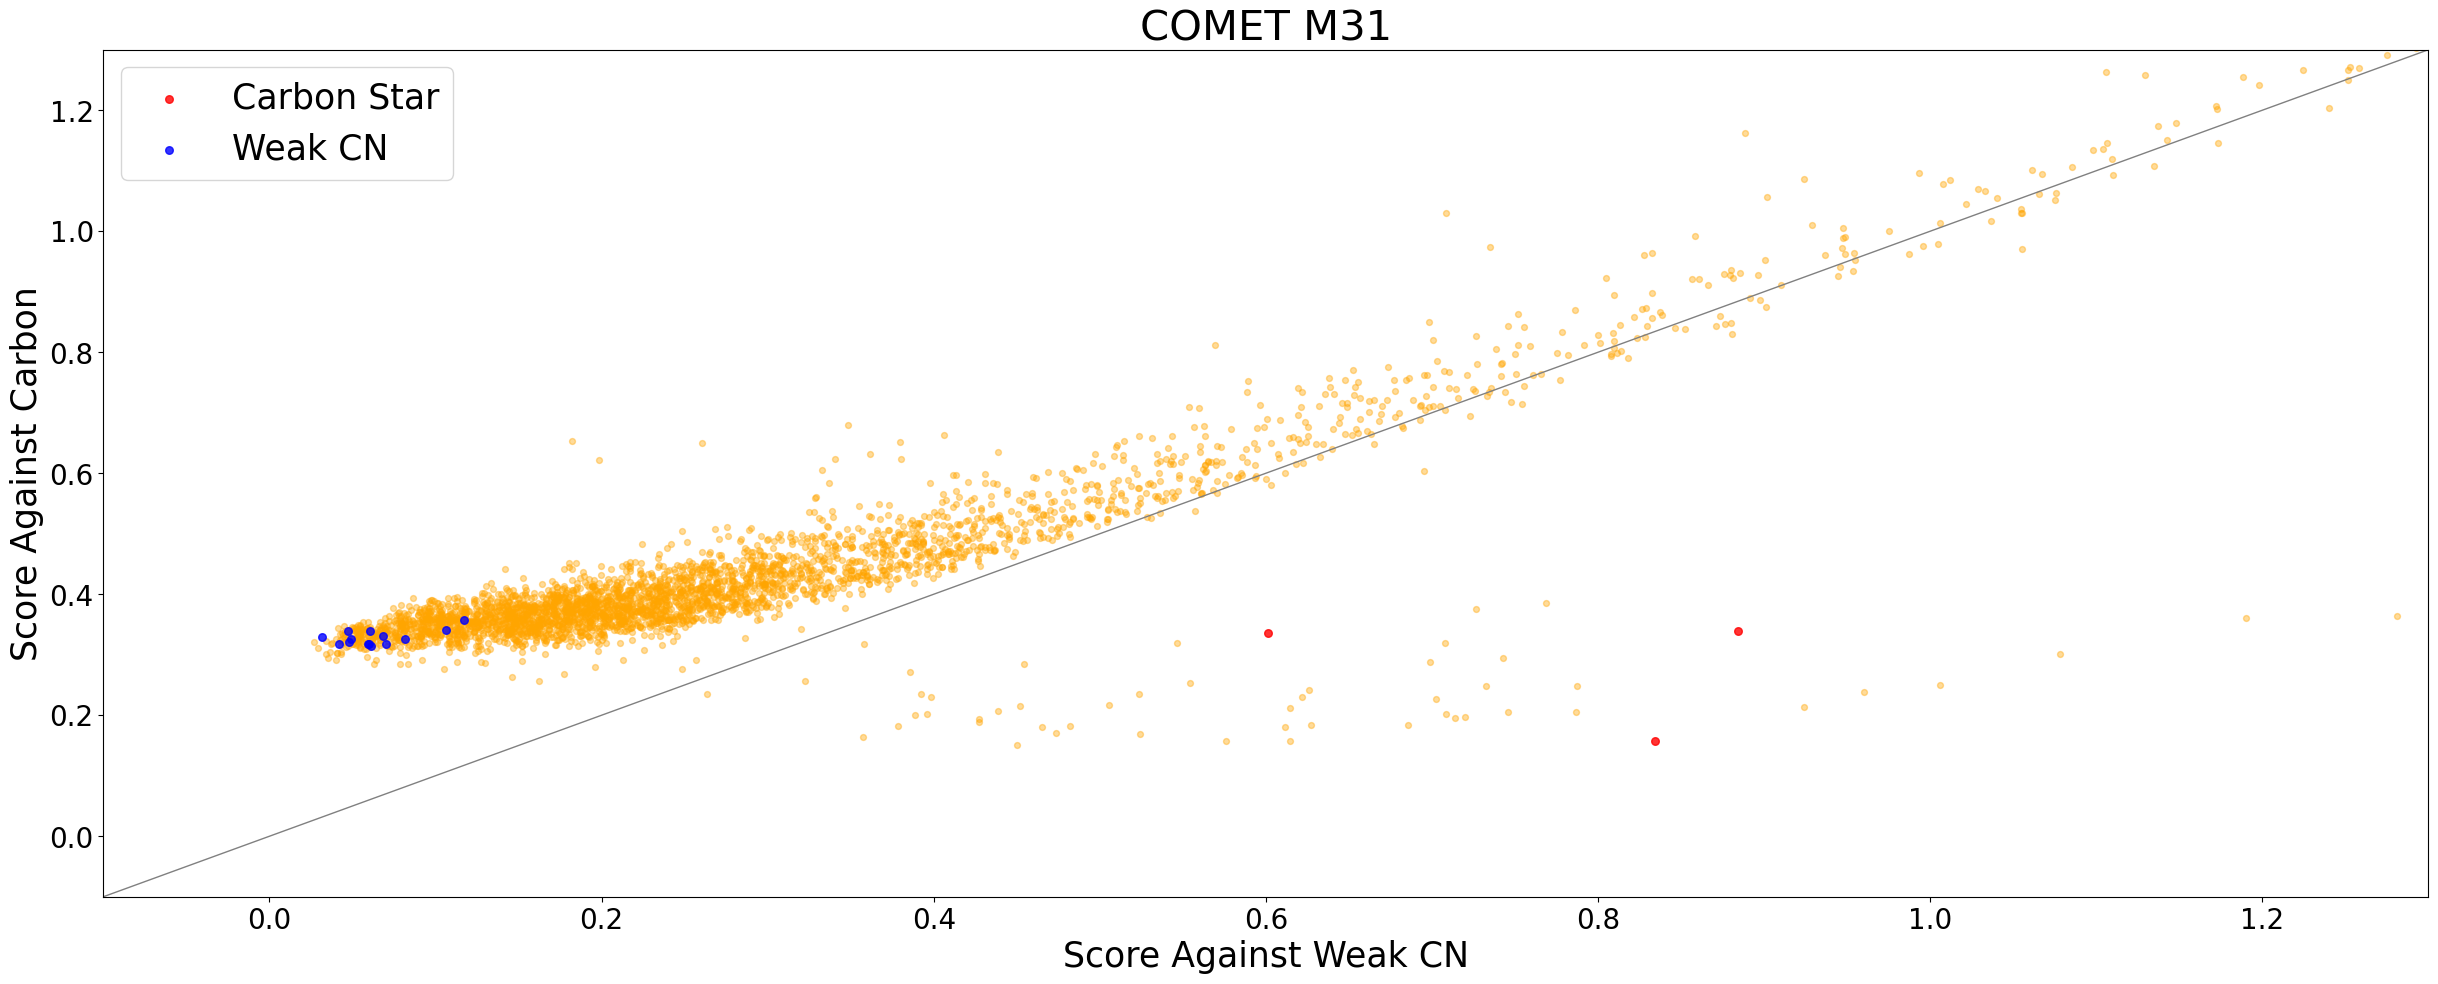

In [29]:
index = np.arange(0, len(chi_squared_list_C), 1)
delete2 = np.append(allcarbon, Wnm)
index = np.delete(index, delete2)

plt.rcParams['figure.figsize'] = 30,11
plt.scatter(chi_squared_list_WCN[index],chi_squared_list_C[index], alpha=0.4, c='orange', s=18)
plt.scatter(chi_squared_list_WCN[allcarbon],chi_squared_list_C[allcarbon], alpha=0.8, c='red', label='Carbon Star', s=30)
plt.scatter(chi_squared_list_WCN[Wnm],chi_squared_list_C[Wnm], alpha=0.8, c='blue', label='Weak CN', s=30)
plt.legend(fontsize=25)

x = [-300,300]
plt.plot(x,x,c='grey', lw=1)
plt.ylabel('Score Against Carbon', fontsize=25)
plt.xlabel('Score Against Weak CN', fontsize=25)
plt.title('COMET M31', fontsize=30)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.xlim(-0.1,1.3)
plt.ylim(-0.1,1.3)

### Getting D

In [30]:
import math  
from scipy.spatial.distance import cdist


#create arrays for the comet plot x,y values
all_x = chi_squared_list_WCN
all_y = chi_squared_list_C
others_x = chi_squared_list_WCN[index]
others_y = chi_squared_list_C[index]
wnm_x = chi_squared_list_WCN[Wnm]
wnm_y = chi_squared_list_C[Wnm]
cst_x = chi_squared_list_WCN[allcarbon]
cst_y = chi_squared_list_C[allcarbon]

#combine x,y values into 2d array
all_coord = np.vstack((all_x, all_y)).T
others_coord = np.vstack((others_x, others_y)).T
wnm_coord = np.vstack((wnm_x, wnm_y)).T
cst_coord = np.vstack((cst_x, cst_y)).T

#set up arbitrary reference coordinate - the head of the comet plot
xc = np.array(0.0)
yc =np.array(0.34) 

reference_coord = np.vstack((xc,yc)).T

#calculate distances between reference point and coordinates of stars
#result saved in an array
all_dist = cdist(reference_coord,all_coord)
others_dist = cdist(reference_coord,others_coord)
wnm_dist = cdist(reference_coord,wnm_coord)
cst_dist = cdist(reference_coord,cst_coord)

#confirm length of arrays. All dist should be the sum of the other 3
print(others_dist.size)
print(wnm_dist.size)
print(cst_dist.size)
print(all_dist.size)

#was tested and confirmed that distances are correct

3421
14
6
3441


In [31]:
#calculating exponential formula to weight point size on plots

#max and min point size based on max and min distance
#rachel- or we can choose aribitrary values
p_max = 100
p_min = 10

#free parameter D_0 can be used to control the distribution of point sizes
D_0 = 0.075

'''
D is the distance from the comet head
A small value of D_0 (say 0.5 or less) will result in
only a few large points and most of the points will be small. 
A large value of D_0 (say 5) will result in most points being large.
'''

weight_all =[]
weight_others =[]
weight_wnm=[]
weight_cst=[]

for D in np.nditer(all_dist):
    weight1 = (p_max - p_min)* math.exp(- D/D_0) + p_min
    weight_all.append(weight1)
    
for D in np.nditer(others_dist):
    weight1 = (p_max - p_min)* math.exp(- D/D_0) + p_min
    weight_others.append(weight1)

    
for D in np.nditer(wnm_dist):
    weight1 = (p_max - p_min)* math.exp(- D/D_0) + p_min
    weight_wnm.append(weight1)

for D in np.nditer(cst_dist):
    weight1 = (p_max - p_min)* math.exp(- D/D_0) + p_min
    weight_cst.append(weight1)
    
    #need to check and confirm calculations for each weight arrayü
weight_all= np.asarray(weight_all)

If everything is working properly, then the weak cn stars should be the ones where the weight parameter is greater than about 60. Grab the weight_all array and find the indexes where its above 60. Those should be all the weak cn stars in the sample

(-0.1, 1.3)

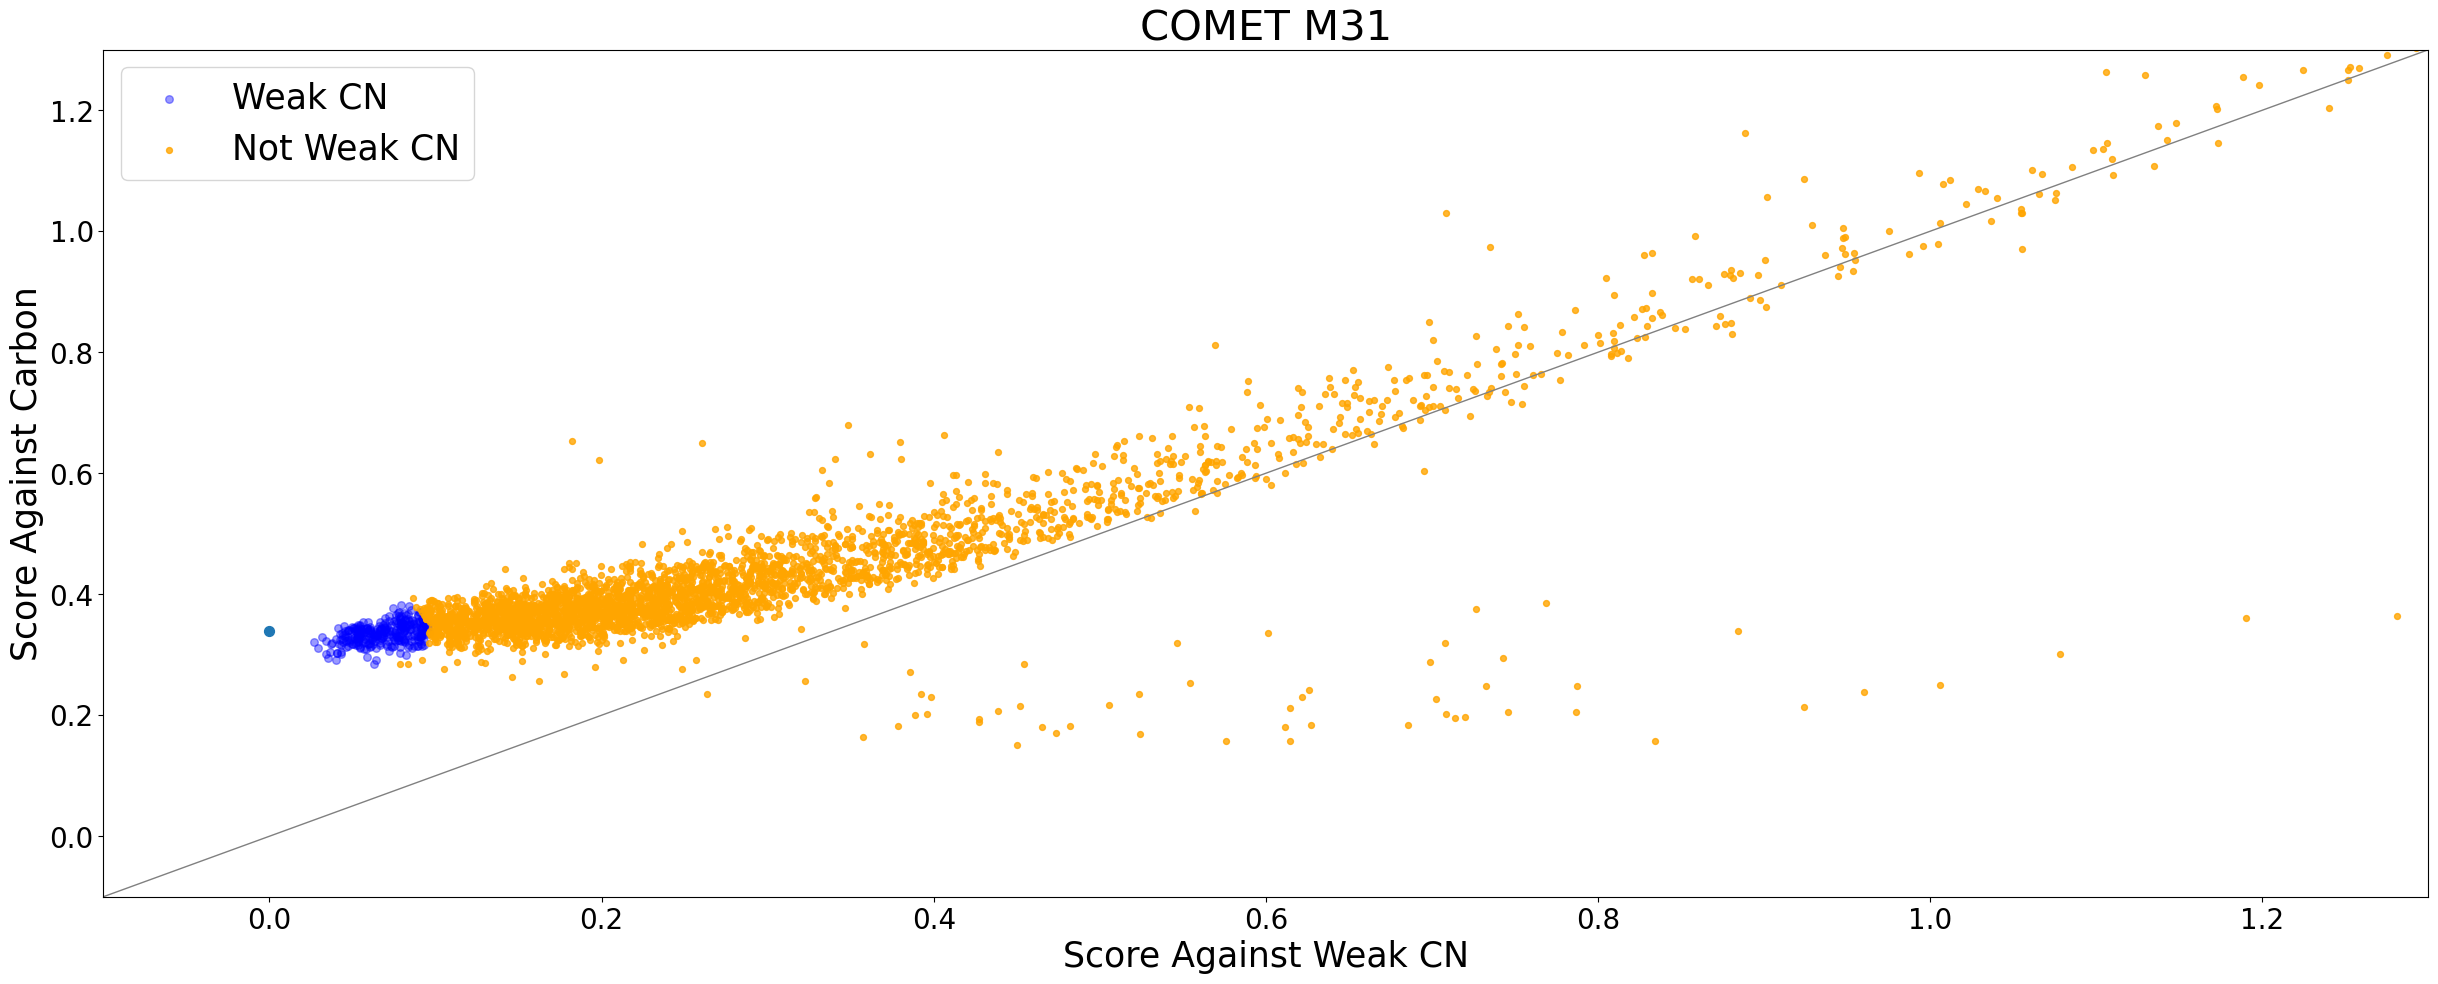

In [32]:
is_weakcn = np.where((weight_all>=35))[0]

all_stars = np.arange(0, len(chi_squared_list_C), 1)
not_weakcn = np.delete(all_stars, is_weakcn)

plt.rcParams['figure.figsize'] = 30,11
plt.scatter(chi_squared_list_WCN[is_weakcn],chi_squared_list_C[is_weakcn], alpha=0.4, c='blue', label='Weak CN', s=30)
plt.scatter(chi_squared_list_WCN[not_weakcn],chi_squared_list_C[not_weakcn], alpha=0.8, c='orange', label='Not Weak CN', s=18)
plt.legend(fontsize=25)
plt.scatter(xc, yc, s=50)

x = [-300,300]
plt.plot(x,x,c='grey', lw=1)
plt.ylabel('Score Against Carbon', fontsize=25)
plt.xlabel('Score Against Weak CN', fontsize=25)
plt.title('COMET M31', fontsize=30)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.xlim(-0.1,1.3)
plt.ylim(-0.1,1.3)

290
304


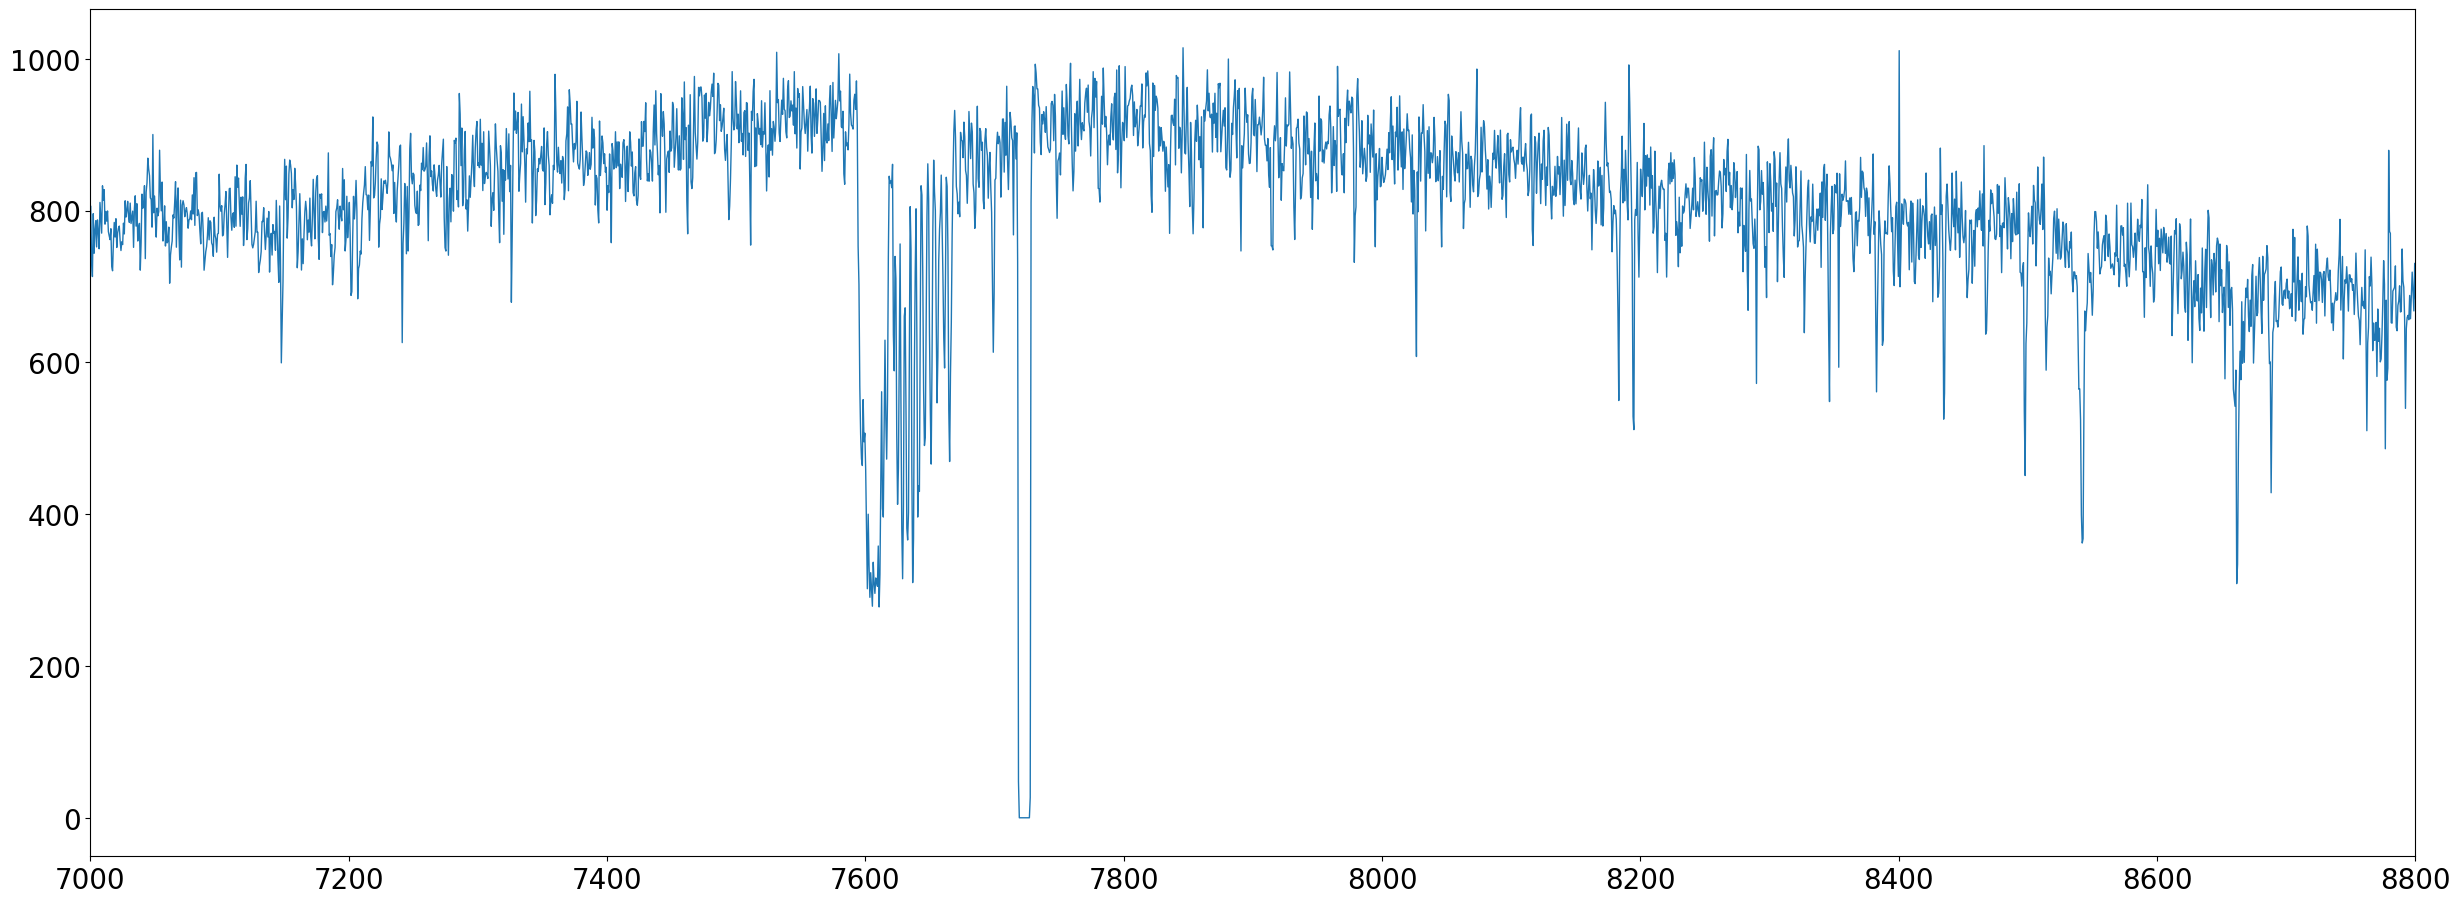

In [33]:
weakcn_flux = flux[is_weakcn, :]
weakcn_wav = wavln[is_weakcn, :]

rnd = random.randint(0, len(is_weakcn)) #Selects a random star in the weak cn sample
print(rnd) #prints its index. Check if the stars look like they are all (or at least mostly) weak cn

plt.figure(figsize=(30,11)) #plots the spectra
plt.plot(weakcn_wav[rnd,:], weakcn_flux[rnd,:], lw=1)
plt.xlim(7000, 8800)
print(len(is_weakcn))

303
304


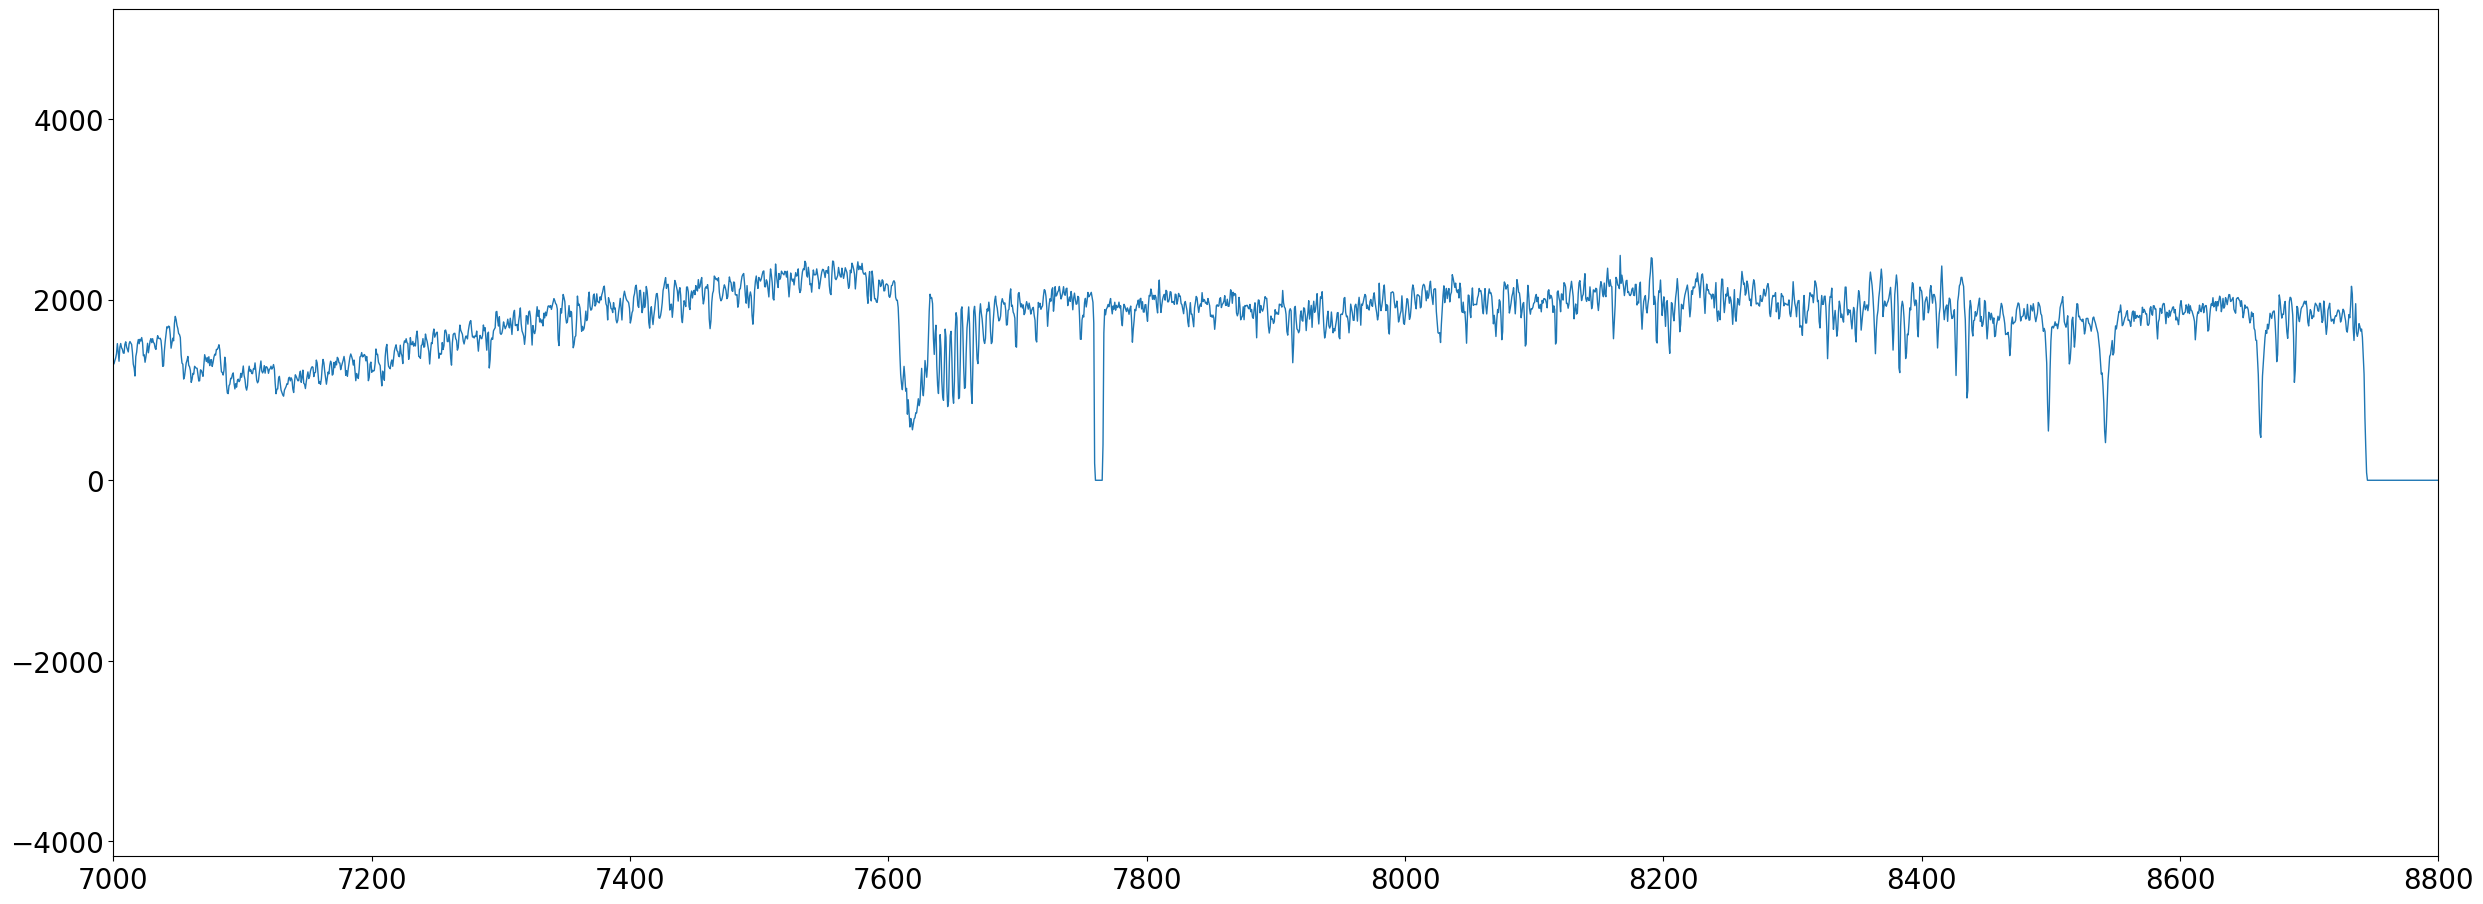

In [34]:
weakcn_flux = flux[is_weakcn, :]
weakcn_wav = wavln[is_weakcn, :]

n = 303
print(n) 

plt.figure(figsize=(30,11)) #plots the spectra
plt.plot(weakcn_wav[n,:], weakcn_flux[n,:], lw=1)
plt.xlim(7000, 8800)
print(len(is_weakcn))

In [35]:
print(is_weakcn, len(is_weakcn))

[ 172  436  443  444  447  448  450  451  452  454  455  457  458  459
  460  465  466  489  493  499  507  596  717  735  766  782  784  790
  791  792  795  800  801  815  818  841  854 1103 1106 1107 1108 1110
 1111 1114 1115 1150 1180 1181 1186 1187 1188 1189 1190 1191 1194 1418
 1420 1443 1445 1474 1491 1497 1508 1519 1528 1539 1541 1542 1543 1544
 1546 1547 1549 1551 1552 1553 1554 1556 1557 1702 1732 1734 1747 1755
 1769 1774 1776 1778 1850 1853 1870 1873 1878 1879 1880 1882 1883 1884
 1902 1904 1905 1913 1916 1997 1998 2002 2003 2007 2008 2009 2016 2017
 2072 2073 2076 2083 2101 2102 2104 2105 2106 2109 2110 2111 2112 2113
 2116 2117 2119 2123 2125 2127 2128 2129 2131 2136 2137 2167 2168 2171
 2172 2173 2177 2178 2179 2180 2183 2185 2186 2188 2190 2191 2192 2193
 2206 2254 2255 2256 2257 2259 2261 2263 2264 2267 2268 2279 2281 2285
 2286 2289 2290 2293 2295 2296 2299 2301 2308 2317 2394 2397 2398 2399
 2400 2402 2438 2461 2475 2551 2552 2553 2555 2557 2562 2573 2574 2575
 2581 

In [36]:
is_weakcn_new = is_weakcn

n = [0, 1, 4, 10, 12, 14, 15, 20, 21, 22, 23, 24, 25, 27, 34, 35, 37, 38, 41, 45, 47, 51, 53, 54, 56, 59, 60, 62, 65, 66, 67, 69, 74, 77, 79, 80, 82, 83, 87, 88, 89, 90, 97, 101, 103, 104, 106, 108, 109, 110, 111, 112, 115, 117, 122, 127, 130, 131, 132, 133, 137, 138, 140, 144, 144, 148, 151, 154, 156, 157, 160, 163, 164, 166, 168, 170, 171, 174, 175, 176, 177, 178, 182, 183, 184, 186, 191, 196, 199, 200, 203, 204, 207, 208, 210, 211, 212, 214, 215, 216, 219, 220, 222, 223, 224, 225, 226, 229, 233, 234, 236, 237, 238, 240, 241, 245, 247, 248, 254, 256, 257, 258, 261, 265, 272, 281, 284, 286, 290, 291, 295, 299, 301, 302, 303, ]
i = 0
for x in n:
    x+=i
    is_weakcn_new = np.delete(is_weakcn_new, x)
    i-=1
    

for x in is_weakcn_new:
    print(x)

443
444
448
450
451
452
454
457
459
466
489
493
499
784
791
792
795
800
801
815
854
1107
1108
1111
1114
1115
1180
1186
1187
1188
1190
1418
1443
1445
1497
1519
1528
1543
1546
1547
1549
1551
1553
1554
1557
1734
1769
1774
1776
1873
1878
1879
1880
1882
1883
1902
1904
1905
1916
2002
2007
2073
2076
2101
2104
2105
2106
2109
2111
2112
2113
2116
2119
2123
2131
2136
2137
2171
2173
2177
2180
2183
2185
2188
2190
2192
2193
2254
2257
2259
2263
2264
2279
2285
2289
2295
2296
2397
2398
2399
2461
2551
2552
2553
2555
2562
2573
2574
2575
2591
2599
2647
2648
2657
2659
2678
2805
2859
2864
2887
2894
2895
2898
2899
2900
2903
2912
2916
2917
2919
2925
2929
2930
2931
2932
2935
2942
3045
3046
3050
3051
3054
3066
3089
3091
3092
3093
3096
3102
3103
3104
3105
3106
3109
3110
3111
3116
3119
3183
3187
3189
3190
3230
3232
3233
3290
3291
3293
3312


In [37]:
print(is_weakcn_new)
print(len(is_weakcn_new)) 

[ 443  444  448  450  451  452  454  457  459  466  489  493  499  784
  791  792  795  800  801  815  854 1107 1108 1111 1114 1115 1180 1186
 1187 1188 1190 1418 1443 1445 1497 1519 1528 1543 1546 1547 1549 1551
 1553 1554 1557 1734 1769 1774 1776 1873 1878 1879 1880 1882 1883 1902
 1904 1905 1916 2002 2007 2073 2076 2101 2104 2105 2106 2109 2111 2112
 2113 2116 2119 2123 2131 2136 2137 2171 2173 2177 2180 2183 2185 2188
 2190 2192 2193 2254 2257 2259 2263 2264 2279 2285 2289 2295 2296 2397
 2398 2399 2461 2551 2552 2553 2555 2562 2573 2574 2575 2591 2599 2647
 2648 2657 2659 2678 2805 2859 2864 2887 2894 2895 2898 2899 2900 2903
 2912 2916 2917 2919 2925 2929 2930 2931 2932 2935 2942 3045 3046 3050
 3051 3054 3066 3089 3091 3092 3093 3096 3102 3103 3104 3105 3106 3109
 3110 3111 3116 3119 3183 3187 3189 3190 3230 3232 3233 3290 3291 3293
 3312]
169


In [38]:
np.save("southern_cnstar_file", is_weakcn_new)

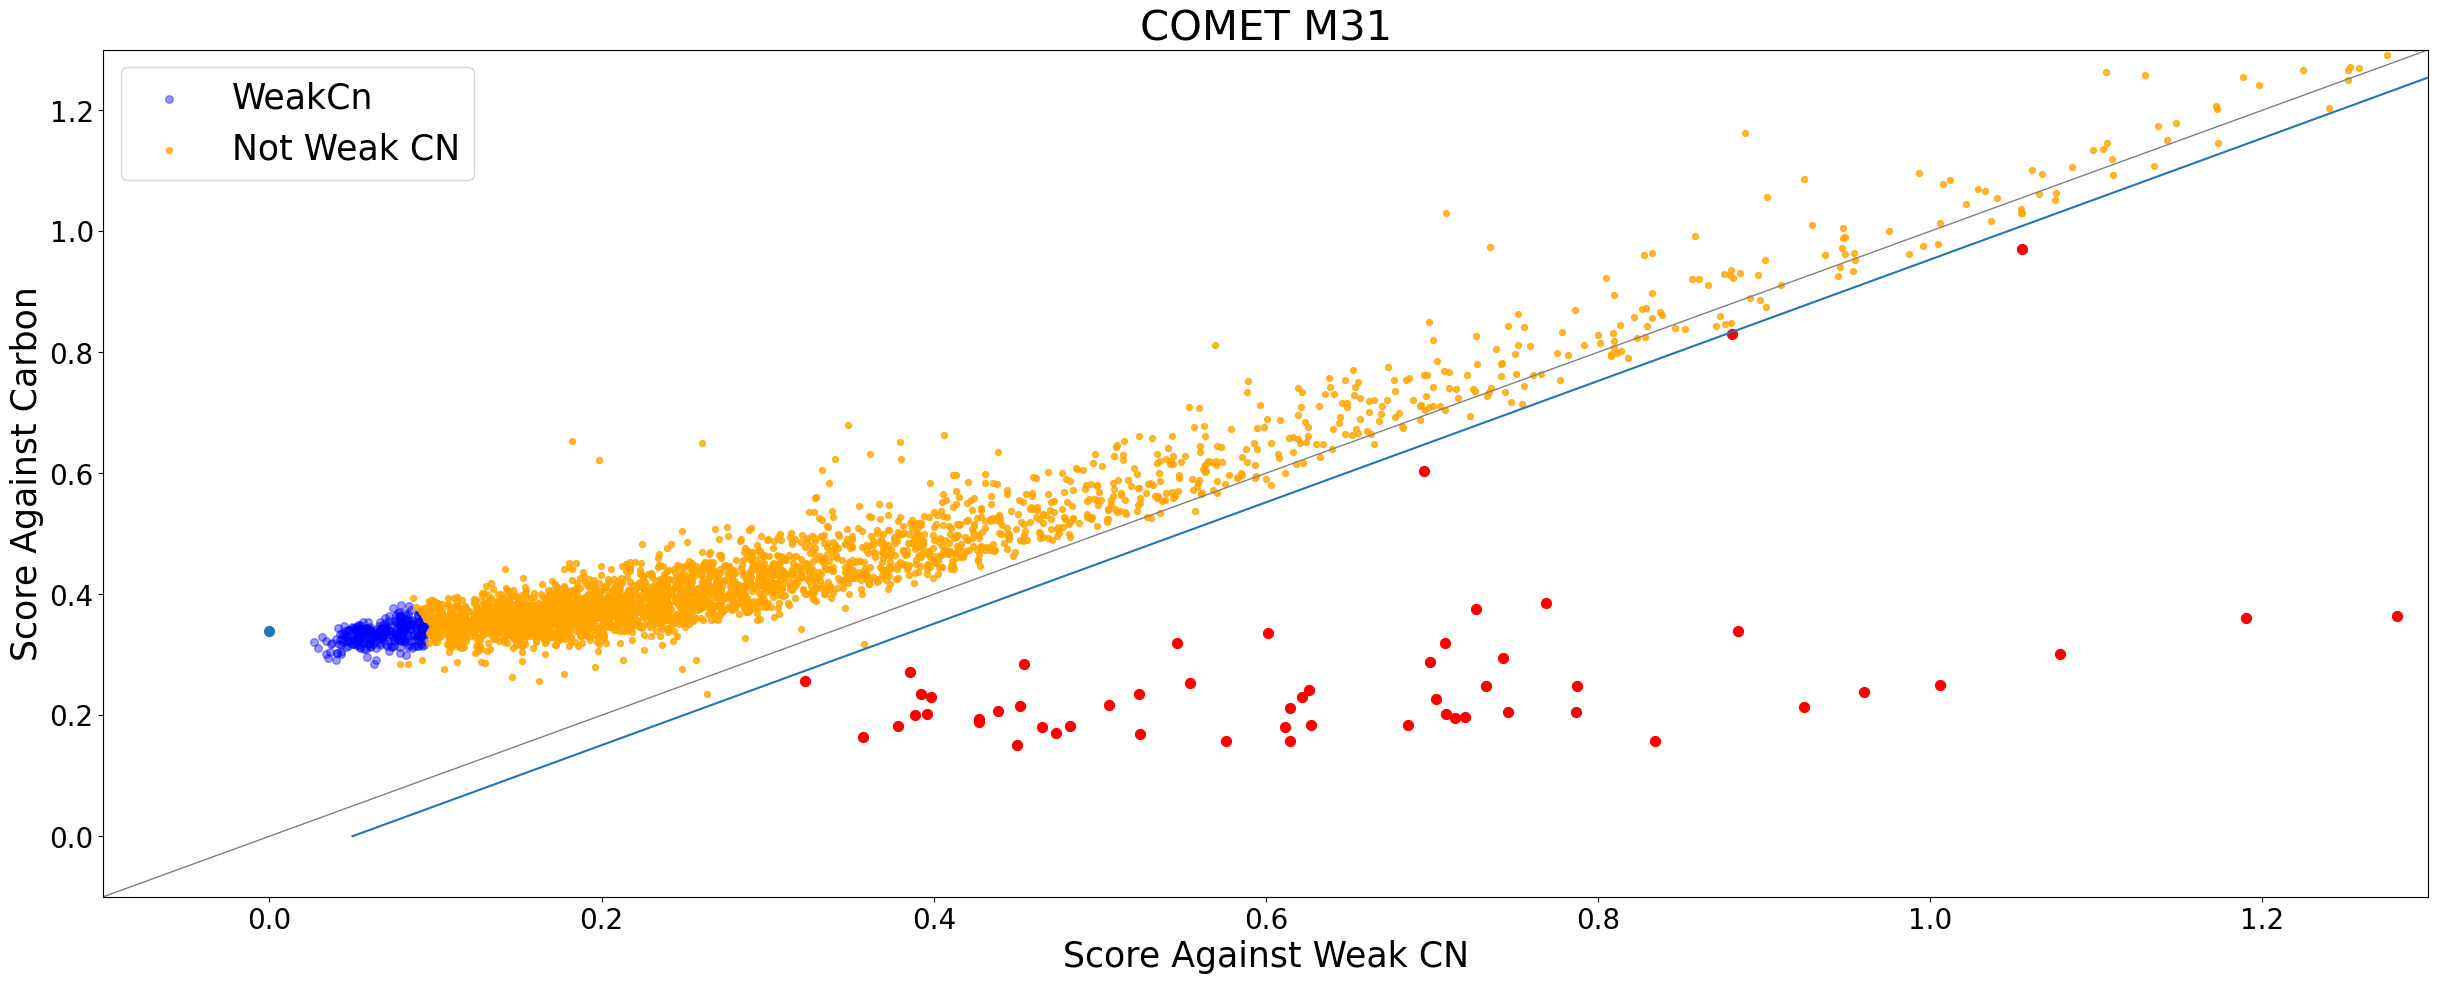

In [39]:

is_weakcn = np.where((weight_all>=35))[0]

all_stars = np.arange(0, len(chi_squared_list_C), 1)
not_weakcn = np.delete(all_stars, is_weakcn)

plt.rcParams['figure.figsize'] = 30,11
plt.scatter(chi_squared_list_WCN[is_weakcn],chi_squared_list_C[is_weakcn], alpha=0.4, c='blue', label='WeakCn', s=30)
plt.scatter(chi_squared_list_WCN[not_weakcn],chi_squared_list_C[not_weakcn], alpha=0.8, c='orange', label='Not Weak CN', s=18)
plt.legend(fontsize=25)
plt.scatter(xc, yc, s=50)

x = [-300,300]
plt.plot(x,x,c='grey', lw=1)
plt.ylabel('Score Against Carbon', fontsize=25)
plt.xlabel('Score Against Weak CN', fontsize=25)
plt.title('COMET M31', fontsize=30)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.xlim(-0.1,1.3)
plt.ylim(-0.1,1.3)

# Use the line just for a referance
axisX = np.linspace(0.05, 15)
axisY = np.linspace(0, 15)
plt.plot(axisX, axisY)

# Highlight the dots below the line
plt.scatter(chi_squared_list_WCN[chi_squared_list_C < chi_squared_list_WCN-0.05], 
            chi_squared_list_C[chi_squared_list_C < chi_squared_list_WCN-0.05],
            c='red', marker='o', s=50, label='Carbon')

is_carbon = np.where(chi_squared_list_C < chi_squared_list_WCN - 0.05)[0]

2
71


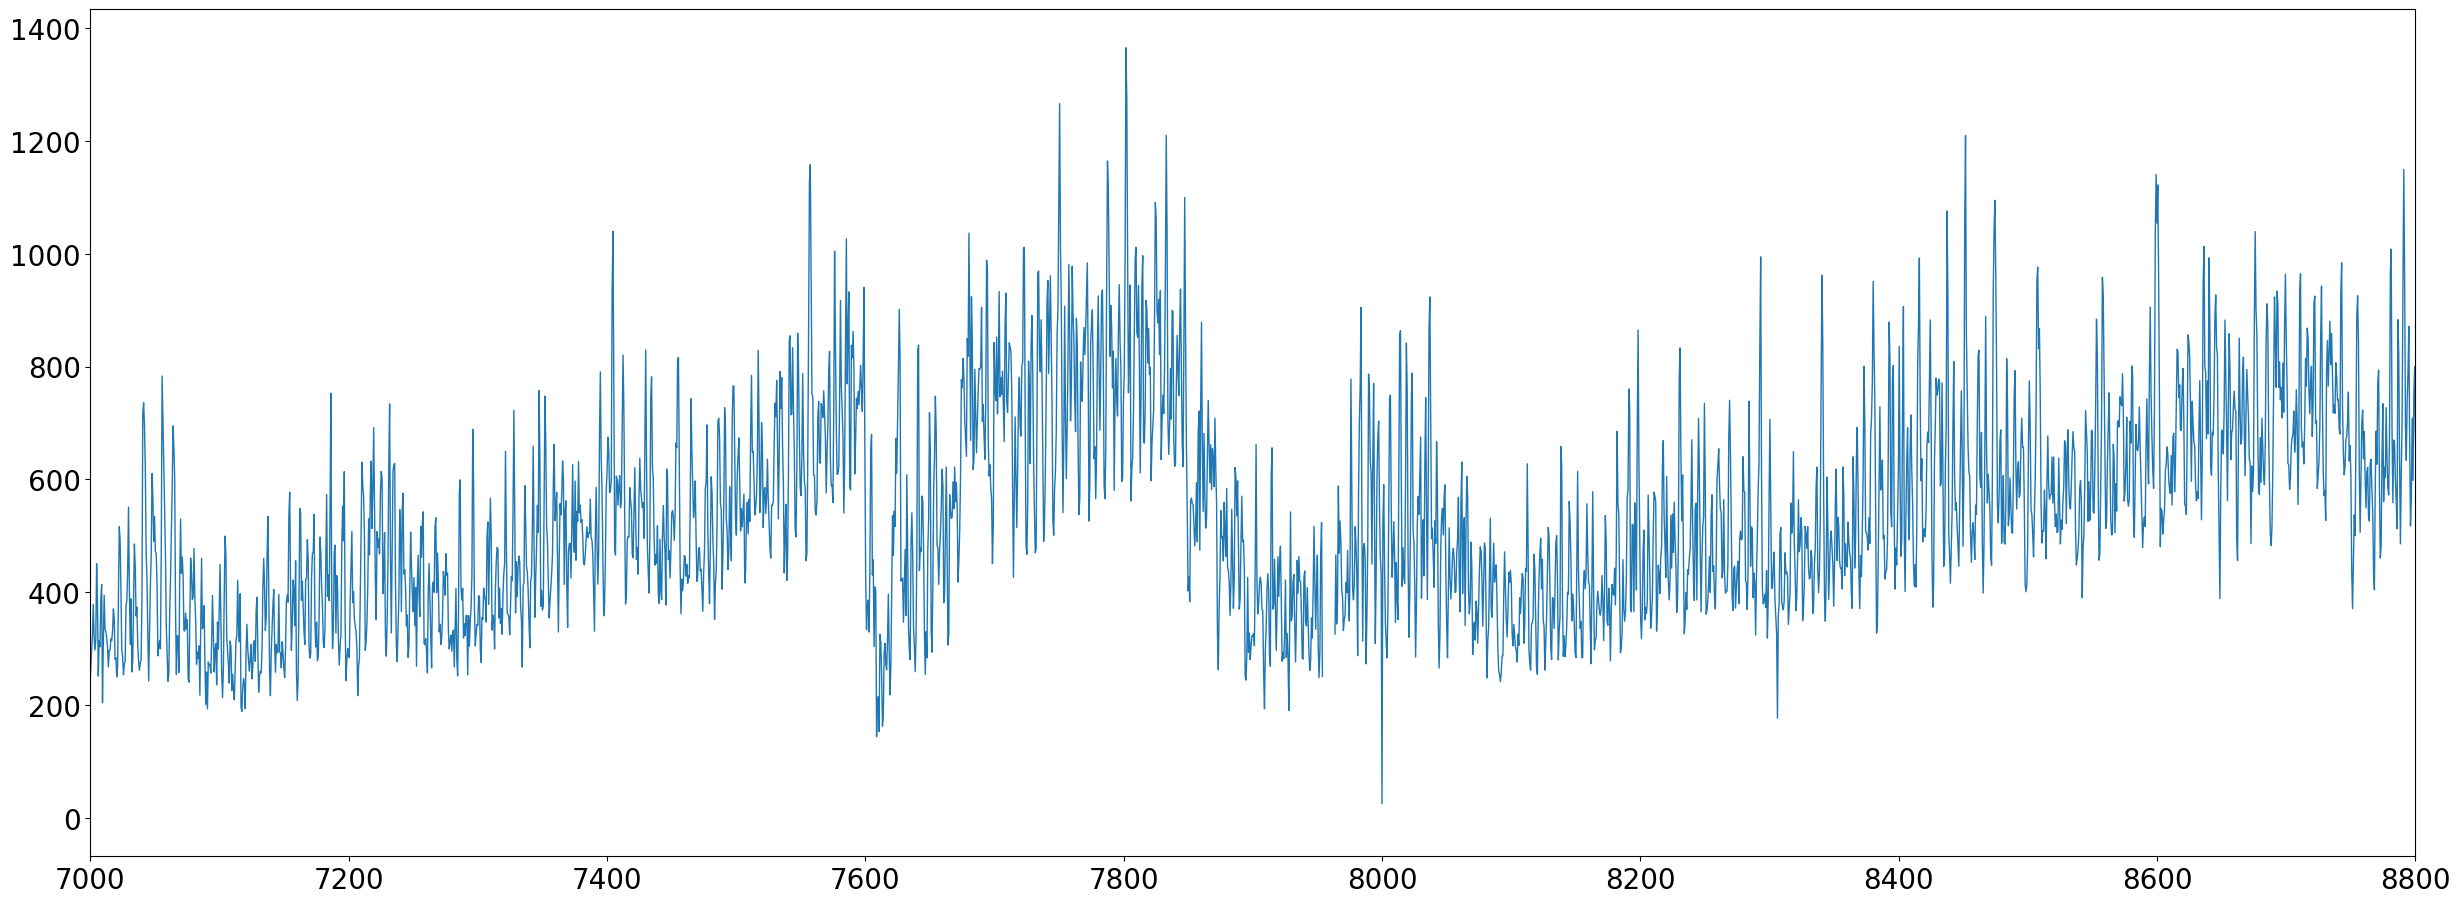

In [40]:
carbon_flux = flux[is_carbon, :]
carbon_wav = wavln[is_carbon, :]

rnd = random.randint(0, len(is_carbon)) 
print(rnd)

plt.figure(figsize=(30,11)) #plots the spectra
plt.plot(carbon_wav[rnd,:], carbon_flux[rnd,:], lw=1)
plt.xlim(7000, 8800)
print(len(is_carbon))

71


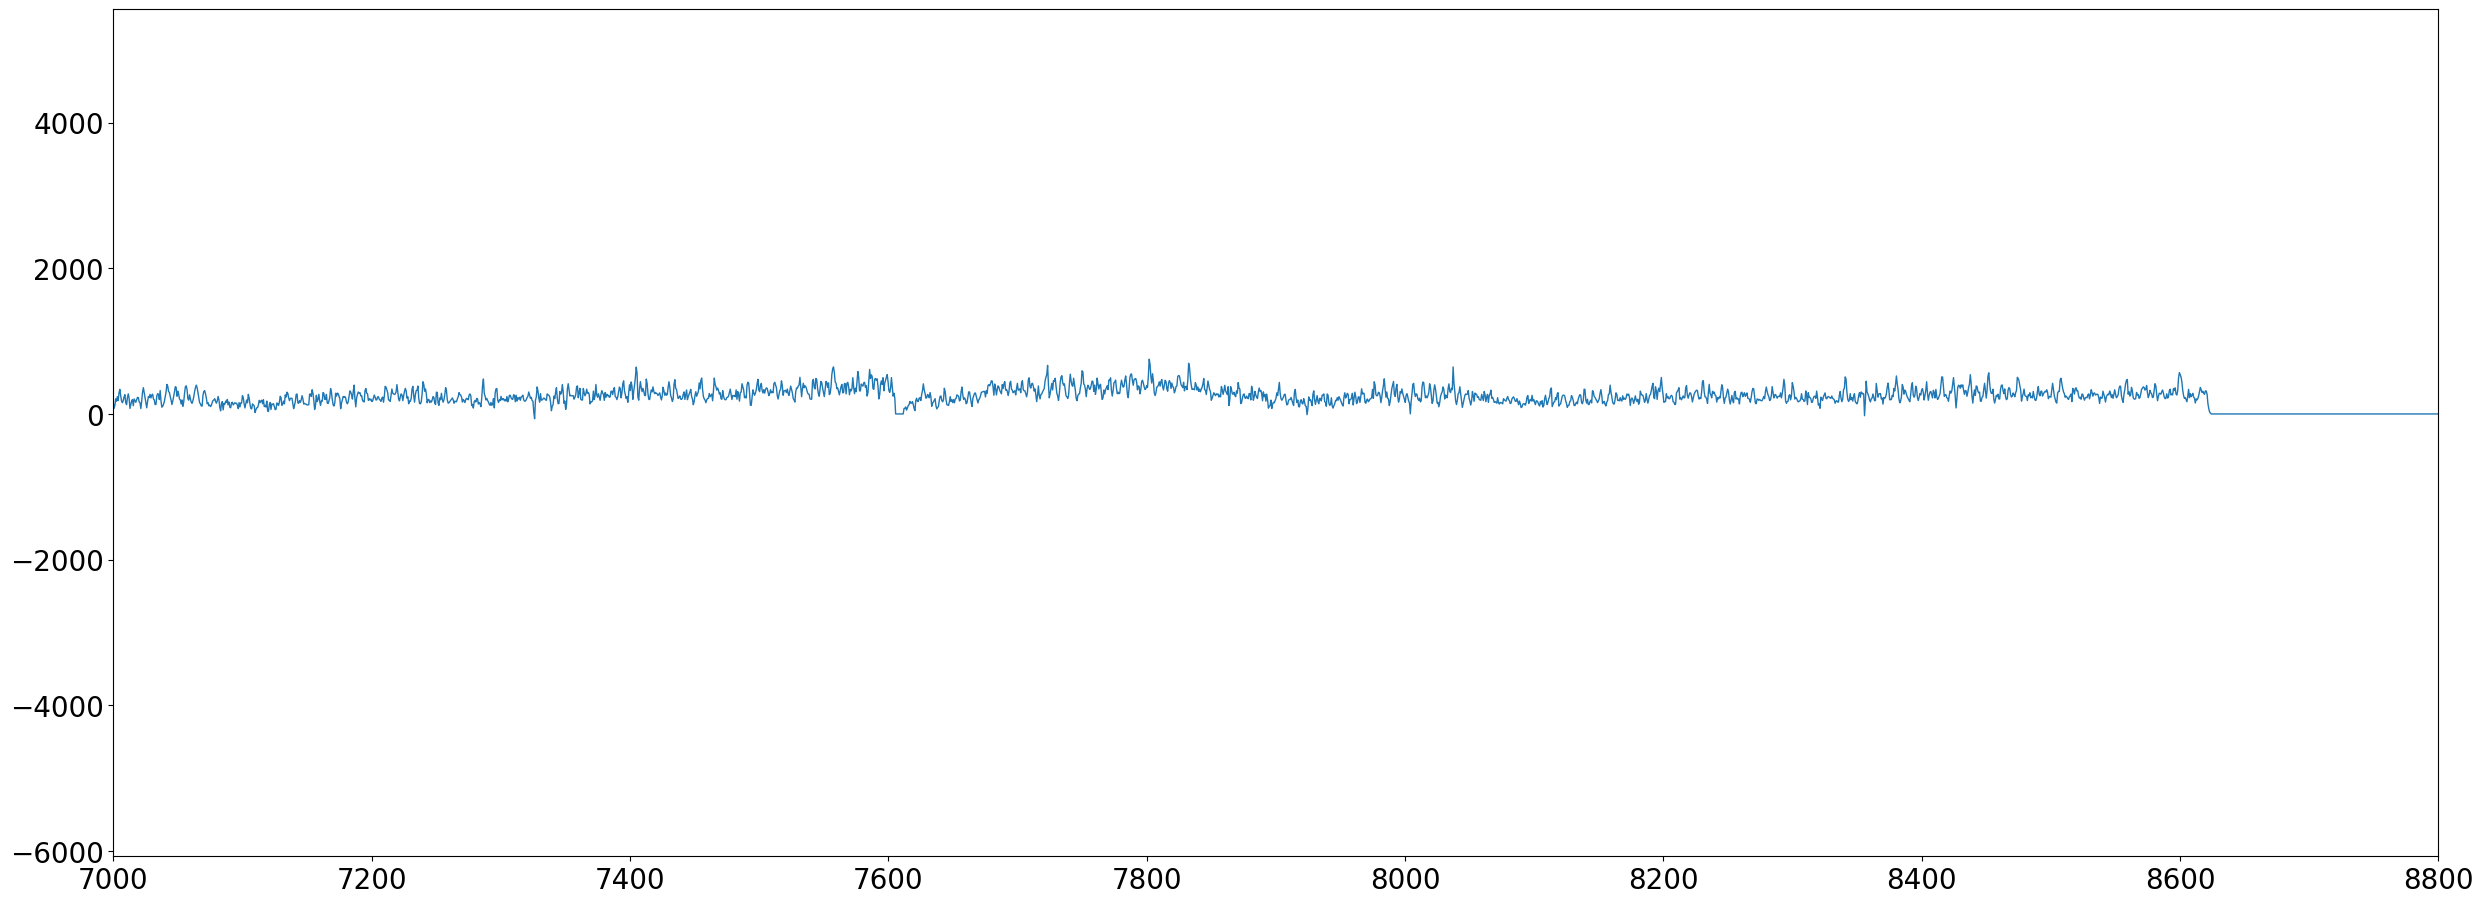

In [114]:
carbon_flux = flux[is_carbon, :]
carbon_wav = wavln[is_carbon, :]

num = 70

plt.figure(figsize=(30,11)) #plots the spectra
plt.plot(carbon_wav[num,:], carbon_flux[num,:], lw=1)
plt.xlim(7000, 8800)
print(len(is_carbon))

In [115]:
print(is_carbon)

[  15  290  377  388  399  421  424  433  437  440  476  484  506  745
  750  763  768  809  813  822 1058 1067 1098 1146 1148 1167 1168 1416
 1427 1429 1461 1481 1483 1499 1598 1694 1741 1748 1752 1781 1832 1857
 2024 2026 2028 2033 2080 2141 2198 2409 2447 2469 2472 2482 2497 2585
 2689 2729 2736 2774 2824 2853 2949 3133 3136 3195 3200 3236 3325 3330
 3433]


In [116]:
is_carbon_new = is_carbon

n = [0, 1, 4, 10, 22, 27, 28, 29, 30, 34, 35, 37, 38, 39, 45, 46, 47, 48, 50, 54, 57, 58, 59, 60, 61, 65, 66, 70]
i = 0
for x in n:
    x+=i
    is_carbon_new = np.delete(is_carbon_new, x)
    i-=1
    

for x in is_carbon_new:
    print(x)

377
388
421
424
433
437
440
484
506
745
750
763
768
809
813
822
1058
1067
1146
1148
1167
1168
1481
1483
1499
1741
1832
1857
2024
2026
2028
2409
2469
2472
2482
2585
2689
2949
3133
3136
3236
3325
3330


In [117]:
print(is_carbon_new)
print(len(is_carbon_new)) 

[ 377  388  421  424  433  437  440  484  506  745  750  763  768  809
  813  822 1058 1067 1146 1148 1167 1168 1481 1483 1499 1741 1832 1857
 2024 2026 2028 2409 2469 2472 2482 2585 2689 2949 3133 3136 3236 3325
 3330]
43
